In [1]:
import time

from torchvision import transforms, datasets
from torch.utils.data import DataLoader



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image




from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

import random



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
bs = 32

In [4]:
# Load Data
dataset = datasets.ImageFolder(root='./', transform=transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)



(12001, 376)

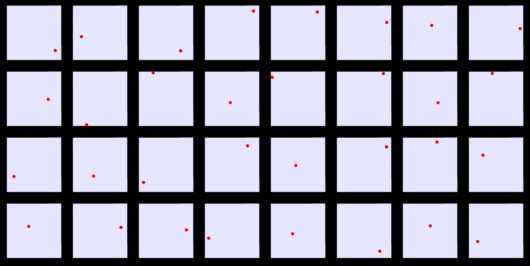

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp.cuda()
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
image_channels = fixed_x.size(1)

In [10]:
model = VAE(image_channels=image_channels).to(device)
model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

<All keys matched successfully>

In [11]:
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [12]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.cuda(), x.cuda(), size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [13]:
##!rm -rfr reconstructed
##!mkdir reconstructed

In [14]:
epochs = 1

In [13]:

model.to(device)
print(device)

cuda


In [16]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [17]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        
        #print(images.shape)
        recon_images, mu, logvar = model(images.to(device))
        
        
        #print(recon_images.shape)
        #print(images.shape)
        
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data.item()/bs, bce.item()/bs, kld.item()/bs)
        print(to_print)

        
        
        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)

# notify to android when finished training
#notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

D:\Anaconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50] Loss: 2356.793 2356.652 0.141
Epoch[1/50] Loss: 2369.234 2369.078 0.156
Epoch[1/50] Loss: 2358.956 2358.810 0.146
Epoch[1/50] Loss: 2361.898 2361.758 0.140
Epoch[1/50] Loss: 2364.208 2364.073 0.135
Epoch[1/50] Loss: 2360.812 2360.690 0.122
Epoch[1/50] Loss: 2358.754 2358.626 0.127
Epoch[1/50] Loss: 2358.690 2358.557 0.134
Epoch[1/50] Loss: 2360.148 2360.013 0.135
Epoch[1/50] Loss: 2359.805 2359.667 0.138
Epoch[1/50] Loss: 2358.671 2358.530 0.140
Epoch[1/50] Loss: 2358.615 2358.472 0.143
Epoch[1/50] Loss: 2358.273 2358.134 0.139
Epoch[1/50] Loss: 2357.826 2357.694 0.133
Epoch[1/50] Loss: 2357.812 2357.675 0.138
Epoch[1/50] Loss: 2358.405 2358.267 0.138
Epoch[1/50] Loss: 2358.109 2357.970 0.138
Epoch[1/50] Loss: 2357.790 2357.662 0.128
Epoch[1/50] Loss: 2357.412 2357.269 0.143
Epoch[1/50] Loss: 2357.696 2357.560 0.136
Epoch[1/50] Loss: 2357.862 2357.730 0.132
Epoch[1/50] Loss: 2357.771 2357.636 0.135
Epoch[1/50] Loss: 2357.948 2357.815 0.134
Epoch[1/50] Loss: 2357.204 2357.06

Epoch[1/50] Loss: 2356.282 2356.123 0.160
Epoch[1/50] Loss: 2356.374 2356.221 0.153
Epoch[1/50] Loss: 2356.794 2356.638 0.156
Epoch[1/50] Loss: 2356.565 2356.414 0.151
Epoch[1/50] Loss: 2356.496 2356.344 0.151
Epoch[1/50] Loss: 2356.234 2356.086 0.148
Epoch[1/50] Loss: 2356.727 2356.586 0.142
Epoch[1/50] Loss: 2356.598 2356.450 0.148
Epoch[1/50] Loss: 2356.682 2356.528 0.154
Epoch[1/50] Loss: 2356.738 2356.581 0.157
Epoch[1/50] Loss: 2356.710 2356.554 0.156
Epoch[1/50] Loss: 2356.577 2356.428 0.149
Epoch[1/50] Loss: 2356.948 2356.798 0.150
Epoch[1/50] Loss: 2356.543 2356.395 0.148
Epoch[1/50] Loss: 2356.936 2356.787 0.148
Epoch[1/50] Loss: 2356.944 2356.793 0.151
Epoch[1/50] Loss: 2356.499 2356.350 0.148
Epoch[1/50] Loss: 2356.580 2356.427 0.153
Epoch[1/50] Loss: 2356.802 2356.643 0.159
Epoch[1/50] Loss: 2356.949 2356.792 0.157
Epoch[1/50] Loss: 2357.209 2357.052 0.158
Epoch[1/50] Loss: 2356.925 2356.778 0.147
Epoch[1/50] Loss: 2356.925 2356.776 0.149
Epoch[1/50] Loss: 2356.547 2356.40

Epoch[2/50] Loss: 2357.273 2357.117 0.155
Epoch[2/50] Loss: 2356.618 2356.470 0.148
Epoch[2/50] Loss: 2356.480 2356.339 0.141
Epoch[2/50] Loss: 2356.964 2356.819 0.145
Epoch[2/50] Loss: 2357.488 2357.347 0.141
Epoch[2/50] Loss: 2357.447 2357.300 0.147
Epoch[2/50] Loss: 2356.964 2356.820 0.144
Epoch[2/50] Loss: 2357.283 2357.126 0.157
Epoch[2/50] Loss: 2358.098 2357.938 0.160
Epoch[2/50] Loss: 2357.508 2357.353 0.156
Epoch[2/50] Loss: 2356.266 2356.119 0.147
Epoch[2/50] Loss: 2357.542 2357.395 0.148
Epoch[2/50] Loss: 2357.818 2357.676 0.142
Epoch[2/50] Loss: 2357.535 2357.387 0.148
Epoch[2/50] Loss: 2356.580 2356.438 0.142
Epoch[2/50] Loss: 2356.923 2356.778 0.145
Epoch[2/50] Loss: 2357.354 2357.204 0.149
Epoch[2/50] Loss: 2357.224 2357.081 0.143
Epoch[2/50] Loss: 2357.632 2357.490 0.143
Epoch[2/50] Loss: 2357.205 2357.068 0.137
Epoch[2/50] Loss: 2356.946 2356.807 0.139
Epoch[2/50] Loss: 2357.338 2357.199 0.139
Epoch[2/50] Loss: 2357.409 2357.263 0.146
Epoch[2/50] Loss: 2357.197 2357.04

Epoch[2/50] Loss: 2356.328 2356.176 0.152
Epoch[2/50] Loss: 2356.667 2356.514 0.152
Epoch[2/50] Loss: 2356.501 2356.347 0.154
Epoch[2/50] Loss: 2356.361 2356.205 0.156
Epoch[2/50] Loss: 2356.557 2356.409 0.148
Epoch[2/50] Loss: 2356.450 2356.302 0.149
Epoch[2/50] Loss: 2356.740 2356.592 0.148
Epoch[2/50] Loss: 2356.590 2356.445 0.144
Epoch[2/50] Loss: 2356.375 2356.229 0.146
Epoch[2/50] Loss: 2356.448 2356.292 0.157
Epoch[2/50] Loss: 2356.332 2356.179 0.153
Epoch[2/50] Loss: 2356.789 2356.633 0.155
Epoch[2/50] Loss: 2356.366 2356.218 0.148
Epoch[2/50] Loss: 2355.821 2355.668 0.152
Epoch[2/50] Loss: 2356.479 2356.321 0.158
Epoch[2/50] Loss: 2355.940 2355.790 0.150
Epoch[2/50] Loss: 2356.348 2356.196 0.152
Epoch[2/50] Loss: 2356.448 2356.288 0.160
Epoch[2/50] Loss: 2356.202 2356.053 0.150
Epoch[2/50] Loss: 2356.644 2356.494 0.150
Epoch[2/50] Loss: 2356.034 2355.888 0.146
Epoch[2/50] Loss: 2356.666 2356.521 0.145
Epoch[2/50] Loss: 2356.198 2356.055 0.143
Epoch[2/50] Loss: 2356.028 2355.88

Epoch[3/50] Loss: 2356.362 2356.207 0.155
Epoch[3/50] Loss: 2355.918 2355.762 0.156
Epoch[3/50] Loss: 2356.086 2355.937 0.149
Epoch[3/50] Loss: 2356.273 2356.126 0.147
Epoch[3/50] Loss: 2355.797 2355.648 0.149
Epoch[3/50] Loss: 2356.389 2356.238 0.151
Epoch[3/50] Loss: 2356.416 2356.261 0.155
Epoch[3/50] Loss: 2356.651 2356.496 0.155
Epoch[3/50] Loss: 2356.172 2356.024 0.148
Epoch[3/50] Loss: 2356.440 2356.287 0.153
Epoch[3/50] Loss: 2355.792 2355.636 0.156
Epoch[3/50] Loss: 2356.679 2356.525 0.154
Epoch[3/50] Loss: 2356.274 2356.119 0.155
Epoch[3/50] Loss: 2356.195 2356.040 0.155
Epoch[3/50] Loss: 2356.594 2356.443 0.152
Epoch[3/50] Loss: 2356.435 2356.283 0.152
Epoch[3/50] Loss: 2356.256 2356.101 0.155
Epoch[3/50] Loss: 2356.278 2356.123 0.155
Epoch[3/50] Loss: 2356.137 2355.990 0.147
Epoch[3/50] Loss: 2356.611 2356.455 0.156
Epoch[3/50] Loss: 2356.515 2356.375 0.140
Epoch[3/50] Loss: 2356.668 2356.516 0.152
Epoch[3/50] Loss: 2356.493 2356.344 0.150
Epoch[3/50] Loss: 2356.289 2356.14

Epoch[3/50] Loss: 2356.243 2356.092 0.152
Epoch[3/50] Loss: 2356.888 2356.739 0.149
Epoch[3/50] Loss: 2356.839 2356.689 0.150
Epoch[3/50] Loss: 2356.685 2356.532 0.152
Epoch[3/50] Loss: 2356.573 2356.424 0.148
Epoch[3/50] Loss: 2356.725 2356.574 0.150
Epoch[3/50] Loss: 2356.596 2356.445 0.151
Epoch[3/50] Loss: 2356.768 2356.626 0.142
Epoch[3/50] Loss: 2356.660 2356.522 0.138
Epoch[3/50] Loss: 2356.976 2356.832 0.144
Epoch[3/50] Loss: 2356.712 2356.566 0.146
Epoch[3/50] Loss: 2356.865 2356.717 0.147
Epoch[3/50] Loss: 2356.657 2356.509 0.147
Epoch[3/50] Loss: 2356.939 2356.797 0.142
Epoch[3/50] Loss: 2357.257 2357.117 0.140
Epoch[3/50] Loss: 2356.050 2355.908 0.141
Epoch[3/50] Loss: 2356.793 2356.649 0.144
Epoch[3/50] Loss: 2356.735 2356.588 0.147
Epoch[3/50] Loss: 2356.597 2356.445 0.152
Epoch[3/50] Loss: 2357.258 2357.111 0.147
Epoch[3/50] Loss: 2357.355 2357.202 0.153
Epoch[3/50] Loss: 2357.313 2357.167 0.146
Epoch[3/50] Loss: 2355.946 2355.809 0.137
Epoch[3/50] Loss: 2356.538 2356.39

Epoch[4/50] Loss: 2357.931 2357.803 0.128
Epoch[4/50] Loss: 2356.764 2356.638 0.126
Epoch[4/50] Loss: 2358.014 2357.879 0.135
Epoch[4/50] Loss: 2357.324 2357.185 0.139
Epoch[4/50] Loss: 2356.857 2356.720 0.136
Epoch[4/50] Loss: 2357.251 2357.117 0.133
Epoch[4/50] Loss: 2356.673 2356.541 0.133
Epoch[4/50] Loss: 2357.142 2357.016 0.127
Epoch[4/50] Loss: 2357.914 2357.785 0.129
Epoch[4/50] Loss: 2357.550 2357.417 0.133
Epoch[4/50] Loss: 2356.444 2356.316 0.129
Epoch[4/50] Loss: 2356.757 2356.626 0.131
Epoch[4/50] Loss: 2357.216 2357.082 0.134
Epoch[4/50] Loss: 2357.223 2357.078 0.145
Epoch[4/50] Loss: 2357.005 2356.863 0.142
Epoch[4/50] Loss: 2357.166 2357.032 0.134
Epoch[4/50] Loss: 2357.502 2357.360 0.142
Epoch[4/50] Loss: 2357.089 2356.949 0.140
Epoch[4/50] Loss: 2357.440 2357.297 0.143
Epoch[4/50] Loss: 2357.056 2356.915 0.141
Epoch[4/50] Loss: 2356.766 2356.619 0.147
Epoch[4/50] Loss: 2356.995 2356.852 0.144
Epoch[4/50] Loss: 2356.874 2356.725 0.148
Epoch[4/50] Loss: 2356.759 2356.61

Epoch[4/50] Loss: 2356.253 2356.109 0.144
Epoch[4/50] Loss: 2356.589 2356.440 0.149
Epoch[4/50] Loss: 2356.429 2356.280 0.149
Epoch[4/50] Loss: 2355.885 2355.736 0.150
Epoch[4/50] Loss: 2356.406 2356.260 0.147
Epoch[4/50] Loss: 2356.359 2356.209 0.150
Epoch[4/50] Loss: 2356.461 2356.308 0.153
Epoch[4/50] Loss: 2356.042 2355.893 0.149
Epoch[4/50] Loss: 2356.179 2356.034 0.145
Epoch[4/50] Loss: 2356.353 2356.202 0.151
Epoch[4/50] Loss: 2355.955 2355.811 0.145
Epoch[4/50] Loss: 2356.629 2356.474 0.154
Epoch[4/50] Loss: 2356.211 2356.063 0.148
Epoch[4/50] Loss: 2356.201 2356.052 0.149
Epoch[4/50] Loss: 2356.109 2355.959 0.149
Epoch[4/50] Loss: 2357.103 2356.954 0.149
Epoch[4/50] Loss: 2356.035 2355.897 0.137
Epoch[4/50] Loss: 2356.093 2355.957 0.136
Epoch[4/50] Loss: 2356.235 2356.097 0.138
Epoch[4/50] Loss: 2356.218 2356.075 0.143
Epoch[4/50] Loss: 2356.549 2356.401 0.148
Epoch[4/50] Loss: 2356.403 2356.261 0.141
Epoch[4/50] Loss: 2356.170 2356.020 0.150
Epoch[4/50] Loss: 2355.899 2355.74

Epoch[5/50] Loss: 2356.644 2356.497 0.148
Epoch[5/50] Loss: 2356.332 2356.183 0.148
Epoch[5/50] Loss: 2356.317 2356.166 0.150
Epoch[5/50] Loss: 2356.345 2356.197 0.148
Epoch[5/50] Loss: 2356.422 2356.276 0.146
Epoch[5/50] Loss: 2356.382 2356.234 0.148
Epoch[5/50] Loss: 2355.939 2355.793 0.146
Epoch[5/50] Loss: 2356.556 2356.405 0.151
Epoch[5/50] Loss: 2356.471 2356.320 0.151
Epoch[5/50] Loss: 2356.353 2356.204 0.149
Epoch[5/50] Loss: 2356.431 2356.273 0.158
Epoch[5/50] Loss: 2356.718 2356.567 0.151
Epoch[5/50] Loss: 2356.202 2356.058 0.145
Epoch[5/50] Loss: 2356.488 2356.340 0.148
Epoch[5/50] Loss: 2356.333 2356.186 0.147
Epoch[5/50] Loss: 2356.054 2355.907 0.147
Epoch[5/50] Loss: 2356.159 2356.021 0.138
Epoch[5/50] Loss: 2356.578 2356.441 0.137
Epoch[5/50] Loss: 2356.007 2355.866 0.140
Epoch[5/50] Loss: 2356.336 2356.199 0.138
Epoch[5/50] Loss: 2356.587 2356.447 0.140
Epoch[5/50] Loss: 2566.965 2566.822 0.143
Epoch[5/50] Loss: 2372.835 2372.652 0.183
Epoch[5/50] Loss: 2402.427 2402.19

Epoch[5/50] Loss: 2356.647 2356.457 0.190
Epoch[5/50] Loss: 2356.986 2356.807 0.180
Epoch[5/50] Loss: 2356.989 2356.807 0.182
Epoch[5/50] Loss: 2357.295 2357.109 0.186
Epoch[5/50] Loss: 2357.080 2356.904 0.177
Epoch[5/50] Loss: 2357.324 2357.148 0.176
Epoch[5/50] Loss: 2357.074 2356.903 0.170
Epoch[5/50] Loss: 2356.929 2356.748 0.181
Epoch[5/50] Loss: 2357.033 2356.852 0.181
Epoch[5/50] Loss: 2356.881 2356.700 0.181
Epoch[5/50] Loss: 2356.497 2356.315 0.181
Epoch[5/50] Loss: 2357.111 2356.923 0.187
Epoch[5/50] Loss: 2357.133 2356.960 0.173
Epoch[5/50] Loss: 2356.834 2356.661 0.174
Epoch[5/50] Loss: 2356.946 2356.768 0.178
Epoch[5/50] Loss: 2356.749 2356.569 0.181
Epoch[5/50] Loss: 2356.906 2356.727 0.179
Epoch[5/50] Loss: 2356.881 2356.703 0.178
Epoch[5/50] Loss: 2356.713 2356.536 0.178
Epoch[5/50] Loss: 2356.843 2356.660 0.182
Epoch[5/50] Loss: 2356.857 2356.681 0.176
Epoch[5/50] Loss: 2356.348 2356.155 0.193
Epoch[5/50] Loss: 2356.993 2356.823 0.170
Epoch[5/50] Loss: 2356.884 2356.70

Epoch[6/50] Loss: 2356.357 2356.191 0.166
Epoch[6/50] Loss: 2356.359 2356.185 0.174
Epoch[6/50] Loss: 2356.439 2356.268 0.171
Epoch[6/50] Loss: 2356.292 2356.128 0.163
Epoch[6/50] Loss: 2355.943 2355.770 0.173
Epoch[6/50] Loss: 2356.430 2356.261 0.168
Epoch[6/50] Loss: 2356.933 2356.765 0.168
Epoch[6/50] Loss: 2356.281 2356.109 0.171
Epoch[6/50] Loss: 2356.152 2355.981 0.171
Epoch[6/50] Loss: 2356.477 2356.304 0.173
Epoch[6/50] Loss: 2356.123 2355.945 0.178
Epoch[6/50] Loss: 2356.319 2356.147 0.172
Epoch[6/50] Loss: 2356.708 2356.542 0.166
Epoch[6/50] Loss: 2356.253 2356.087 0.167
Epoch[6/50] Loss: 2356.459 2356.297 0.162
Epoch[6/50] Loss: 2356.542 2356.374 0.169
Epoch[6/50] Loss: 2356.346 2356.186 0.160
Epoch[6/50] Loss: 2356.457 2356.282 0.175
Epoch[6/50] Loss: 2356.324 2356.154 0.170
Epoch[6/50] Loss: 2356.093 2355.929 0.164
Epoch[6/50] Loss: 2356.374 2356.201 0.172
Epoch[6/50] Loss: 2356.448 2356.279 0.170
Epoch[6/50] Loss: 2356.063 2355.900 0.162
Epoch[6/50] Loss: 2356.232 2356.06

Epoch[6/50] Loss: 2357.016 2356.868 0.148
Epoch[6/50] Loss: 2356.736 2356.584 0.152
Epoch[6/50] Loss: 2356.732 2356.588 0.144
Epoch[6/50] Loss: 2356.597 2356.443 0.154
Epoch[6/50] Loss: 2356.716 2356.569 0.147
Epoch[6/50] Loss: 2356.825 2356.678 0.147
Epoch[6/50] Loss: 2356.591 2356.448 0.143
Epoch[6/50] Loss: 2357.002 2356.859 0.143
Epoch[6/50] Loss: 2356.156 2356.011 0.144
Epoch[6/50] Loss: 2356.947 2356.801 0.146
Epoch[6/50] Loss: 2356.914 2356.764 0.150
Epoch[6/50] Loss: 2356.519 2356.370 0.149
Epoch[6/50] Loss: 2356.365 2356.214 0.151
Epoch[6/50] Loss: 2356.413 2356.257 0.156
Epoch[6/50] Loss: 2356.790 2356.637 0.153
Epoch[6/50] Loss: 2356.802 2356.652 0.151
Epoch[6/50] Loss: 2356.620 2356.471 0.149
Epoch[6/50] Loss: 2356.727 2356.574 0.152
Epoch[6/50] Loss: 2356.789 2356.642 0.147
Epoch[6/50] Loss: 2356.579 2356.422 0.157
Epoch[6/50] Loss: 2356.531 2356.373 0.159
Epoch[6/50] Loss: 2356.304 2356.148 0.156
Epoch[6/50] Loss: 2356.851 2356.702 0.149
Epoch[6/50] Loss: 2356.493 2356.33

Epoch[7/50] Loss: 2356.415 2356.255 0.159
Epoch[7/50] Loss: 2355.982 2355.820 0.162
Epoch[7/50] Loss: 2355.980 2355.814 0.165
Epoch[7/50] Loss: 2356.532 2356.366 0.166
Epoch[7/50] Loss: 2356.228 2356.075 0.153
Epoch[7/50] Loss: 2356.429 2356.265 0.164
Epoch[7/50] Loss: 2356.039 2355.882 0.157
Epoch[7/50] Loss: 2356.302 2356.147 0.156
Epoch[7/50] Loss: 2356.258 2356.103 0.155
Epoch[7/50] Loss: 2356.372 2356.219 0.153
Epoch[7/50] Loss: 2355.966 2355.812 0.154
Epoch[7/50] Loss: 2355.553 2355.393 0.160
Epoch[7/50] Loss: 2356.356 2356.199 0.157
Epoch[7/50] Loss: 2356.392 2356.234 0.158
Epoch[7/50] Loss: 2356.074 2355.914 0.160
Epoch[7/50] Loss: 2355.653 2355.492 0.160
Epoch[7/50] Loss: 2356.191 2356.034 0.157
Epoch[7/50] Loss: 2356.220 2356.060 0.160
Epoch[7/50] Loss: 2356.501 2356.347 0.154
Epoch[7/50] Loss: 2356.451 2356.299 0.152
Epoch[7/50] Loss: 2356.120 2355.961 0.159
Epoch[7/50] Loss: 2356.337 2356.177 0.161
Epoch[7/50] Loss: 2356.599 2356.443 0.155
Epoch[7/50] Loss: 2356.229 2356.06

Epoch[7/50] Loss: 2357.312 2357.174 0.138
Epoch[7/50] Loss: 2357.927 2357.787 0.140
Epoch[7/50] Loss: 2357.868 2357.733 0.134
Epoch[7/50] Loss: 2357.947 2357.801 0.146
Epoch[7/50] Loss: 2357.553 2357.412 0.141
Epoch[7/50] Loss: 2357.987 2357.851 0.136
Epoch[7/50] Loss: 2357.098 2356.954 0.144
Epoch[7/50] Loss: 2357.036 2356.894 0.142
Epoch[7/50] Loss: 2357.571 2357.428 0.143
Epoch[7/50] Loss: 2357.053 2356.903 0.150
Epoch[7/50] Loss: 2357.166 2357.013 0.152
Epoch[7/50] Loss: 2357.361 2357.213 0.149
Epoch[7/50] Loss: 2356.868 2356.715 0.152
Epoch[7/50] Loss: 2357.134 2356.979 0.155
Epoch[7/50] Loss: 2357.206 2357.059 0.148
Epoch[7/50] Loss: 2358.035 2357.891 0.144
Epoch[7/50] Loss: 2357.623 2357.476 0.147
Epoch[7/50] Loss: 2356.782 2356.635 0.147
Epoch[7/50] Loss: 2356.792 2356.647 0.144
Epoch[7/50] Loss: 2357.149 2357.007 0.142
Epoch[7/50] Loss: 2357.113 2356.975 0.138
Epoch[7/50] Loss: 2356.706 2356.564 0.142
Epoch[7/50] Loss: 2357.378 2357.239 0.139
Epoch[7/50] Loss: 2356.833 2356.69

Epoch[8/50] Loss: 2356.596 2356.453 0.142
Epoch[8/50] Loss: 2356.408 2356.259 0.149
Epoch[8/50] Loss: 2356.458 2356.314 0.144
Epoch[8/50] Loss: 2356.220 2356.073 0.147
Epoch[8/50] Loss: 2356.084 2355.936 0.148
Epoch[8/50] Loss: 2356.358 2356.205 0.153
Epoch[8/50] Loss: 2356.495 2356.357 0.138
Epoch[8/50] Loss: 2356.547 2356.397 0.150
Epoch[8/50] Loss: 2356.286 2356.141 0.145
Epoch[8/50] Loss: 2356.504 2356.358 0.147
Epoch[8/50] Loss: 2356.149 2356.002 0.147
Epoch[8/50] Loss: 2356.511 2356.363 0.148
Epoch[8/50] Loss: 2356.263 2356.111 0.152
Epoch[8/50] Loss: 2356.504 2356.358 0.146
Epoch[8/50] Loss: 2356.388 2356.242 0.146
Epoch[8/50] Loss: 2356.555 2356.401 0.154
Epoch[8/50] Loss: 2356.463 2356.310 0.153
Epoch[8/50] Loss: 2355.994 2355.846 0.148
Epoch[8/50] Loss: 2356.002 2355.850 0.152
Epoch[8/50] Loss: 2356.265 2356.113 0.152
Epoch[8/50] Loss: 2356.470 2356.324 0.146
Epoch[8/50] Loss: 2356.495 2356.339 0.156
Epoch[8/50] Loss: 2356.470 2356.312 0.158
Epoch[8/50] Loss: 2356.273 2356.11

Epoch[8/50] Loss: 2355.838 2355.680 0.158
Epoch[8/50] Loss: 2356.384 2356.229 0.155
Epoch[8/50] Loss: 2356.134 2355.975 0.159
Epoch[8/50] Loss: 2356.188 2356.022 0.166
Epoch[8/50] Loss: 2356.110 2355.941 0.169
Epoch[8/50] Loss: 2356.196 2356.039 0.157
Epoch[8/50] Loss: 2356.432 2356.276 0.156
Epoch[8/50] Loss: 2356.135 2355.981 0.154
Epoch[8/50] Loss: 2356.260 2356.105 0.155
Epoch[8/50] Loss: 2356.105 2355.941 0.165
Epoch[8/50] Loss: 2356.010 2355.847 0.162
Epoch[8/50] Loss: 2356.281 2356.123 0.158
Epoch[8/50] Loss: 2355.986 2355.836 0.149
Epoch[8/50] Loss: 2355.795 2355.646 0.149
Epoch[8/50] Loss: 2356.287 2356.140 0.147
Epoch[8/50] Loss: 2356.306 2356.150 0.156
Epoch[8/50] Loss: 2355.780 2355.627 0.153
Epoch[8/50] Loss: 2355.822 2355.672 0.150
Epoch[8/50] Loss: 2355.770 2355.612 0.158
Epoch[8/50] Loss: 2356.351 2356.197 0.155
Epoch[8/50] Loss: 2355.963 2355.803 0.160
Epoch[8/50] Loss: 2355.857 2355.701 0.156
Epoch[8/50] Loss: 2356.146 2355.987 0.159
Epoch[8/50] Loss: 2356.329 2356.16

Epoch[9/50] Loss: 2355.684 2355.530 0.154
Epoch[9/50] Loss: 2355.884 2355.732 0.152
Epoch[9/50] Loss: 2355.805 2355.656 0.149
Epoch[9/50] Loss: 2356.210 2356.063 0.148
Epoch[9/50] Loss: 2355.969 2355.822 0.146
Epoch[9/50] Loss: 2356.172 2356.025 0.147
Epoch[9/50] Loss: 2355.994 2355.844 0.151
Epoch[9/50] Loss: 2356.258 2356.106 0.152
Epoch[9/50] Loss: 2356.006 2355.855 0.152
Epoch[9/50] Loss: 2356.240 2356.086 0.154
Epoch[9/50] Loss: 2356.085 2355.930 0.154
Epoch[9/50] Loss: 2356.274 2356.115 0.160
Epoch[9/50] Loss: 2356.010 2355.849 0.161
Epoch[9/50] Loss: 2356.197 2356.040 0.156
Epoch[9/50] Loss: 2355.976 2355.819 0.157
Epoch[9/50] Loss: 2356.081 2355.927 0.155
Epoch[9/50] Loss: 2356.053 2355.895 0.159
Epoch[9/50] Loss: 2356.331 2356.175 0.156
Epoch[9/50] Loss: 2355.968 2355.821 0.147
Epoch[9/50] Loss: 2356.000 2355.847 0.154
Epoch[9/50] Loss: 2356.085 2355.936 0.149
Epoch[9/50] Loss: 2355.706 2355.556 0.150
Epoch[9/50] Loss: 2356.025 2355.870 0.156
Epoch[9/50] Loss: 2356.274 2356.11

Epoch[9/50] Loss: 2356.542 2356.389 0.153
Epoch[9/50] Loss: 2355.979 2355.831 0.148
Epoch[9/50] Loss: 2355.833 2355.679 0.153
Epoch[9/50] Loss: 2356.662 2356.509 0.153
Epoch[9/50] Loss: 2356.693 2356.540 0.153
Epoch[9/50] Loss: 2356.563 2356.406 0.157
Epoch[9/50] Loss: 2356.265 2356.121 0.145
Epoch[9/50] Loss: 2356.441 2356.293 0.148
Epoch[9/50] Loss: 2356.409 2356.253 0.155
Epoch[9/50] Loss: 2356.695 2356.542 0.153
Epoch[9/50] Loss: 2356.375 2356.219 0.156
Epoch[9/50] Loss: 2356.327 2356.177 0.150
Epoch[9/50] Loss: 2356.594 2356.438 0.155
Epoch[9/50] Loss: 2356.761 2356.605 0.156
Epoch[9/50] Loss: 2356.600 2356.445 0.155
Epoch[9/50] Loss: 2356.728 2356.577 0.152
Epoch[9/50] Loss: 2356.142 2355.987 0.156
Epoch[9/50] Loss: 2356.699 2356.552 0.147
Epoch[9/50] Loss: 2356.510 2356.363 0.148
Epoch[9/50] Loss: 2355.774 2355.625 0.149
Epoch[9/50] Loss: 2356.506 2356.355 0.151
Epoch[9/50] Loss: 2356.676 2356.527 0.148
Epoch[9/50] Loss: 2356.497 2356.342 0.155
Epoch[9/50] Loss: 2356.217 2356.06

Epoch[10/50] Loss: 2355.752 2355.595 0.156
Epoch[10/50] Loss: 2356.210 2356.051 0.159
Epoch[10/50] Loss: 2356.585 2356.420 0.164
Epoch[10/50] Loss: 2356.636 2356.480 0.156
Epoch[10/50] Loss: 2356.475 2356.325 0.149
Epoch[10/50] Loss: 2356.287 2356.135 0.152
Epoch[10/50] Loss: 2356.433 2356.276 0.156
Epoch[10/50] Loss: 2356.167 2356.005 0.162
Epoch[10/50] Loss: 2356.492 2356.343 0.149
Epoch[10/50] Loss: 2356.116 2355.965 0.151
Epoch[10/50] Loss: 2356.311 2356.159 0.152
Epoch[10/50] Loss: 2355.891 2355.738 0.152
Epoch[10/50] Loss: 2356.369 2356.220 0.149
Epoch[10/50] Loss: 2356.010 2355.861 0.150
Epoch[10/50] Loss: 2356.115 2355.963 0.152
Epoch[10/50] Loss: 2356.744 2356.594 0.150
Epoch[10/50] Loss: 2356.321 2356.167 0.153
Epoch[10/50] Loss: 2356.185 2356.039 0.146
Epoch[10/50] Loss: 2356.157 2356.008 0.149
Epoch[10/50] Loss: 2356.467 2356.312 0.154
Epoch[10/50] Loss: 2355.823 2355.670 0.153
Epoch[10/50] Loss: 2356.425 2356.283 0.142
Epoch[10/50] Loss: 2356.383 2356.226 0.158
Epoch[10/50

Epoch[10/50] Loss: 2356.527 2356.379 0.147
Epoch[10/50] Loss: 2356.599 2356.446 0.153
Epoch[10/50] Loss: 2356.520 2356.362 0.157
Epoch[10/50] Loss: 2356.198 2356.046 0.153
Epoch[10/50] Loss: 2356.451 2356.301 0.150
Epoch[10/50] Loss: 2356.363 2356.212 0.150
Epoch[10/50] Loss: 2356.345 2356.188 0.157
Epoch[10/50] Loss: 2356.210 2356.045 0.165
Epoch[10/50] Loss: 2356.550 2356.392 0.158
Epoch[10/50] Loss: 2356.536 2356.377 0.159
Epoch[10/50] Loss: 2356.387 2356.229 0.158
Epoch[10/50] Loss: 2356.316 2356.171 0.146
Epoch[10/50] Loss: 2356.457 2356.304 0.153
Epoch[10/50] Loss: 2356.279 2356.128 0.151
Epoch[10/50] Loss: 2356.471 2356.326 0.145
Epoch[10/50] Loss: 2356.570 2356.424 0.146
Epoch[10/50] Loss: 2356.854 2356.704 0.150
Epoch[10/50] Loss: 2356.447 2356.298 0.149
Epoch[10/50] Loss: 2356.943 2356.782 0.161
Epoch[10/50] Loss: 2356.425 2356.274 0.151
Epoch[10/50] Loss: 2356.458 2356.299 0.159
Epoch[10/50] Loss: 2356.345 2356.188 0.158
Epoch[10/50] Loss: 73.799 73.667 0.132
Epoch[11/50] Lo

Epoch[11/50] Loss: 2356.413 2356.268 0.145
Epoch[11/50] Loss: 2356.366 2356.220 0.146
Epoch[11/50] Loss: 2356.385 2356.242 0.143
Epoch[11/50] Loss: 2356.173 2356.032 0.141
Epoch[11/50] Loss: 2356.393 2356.248 0.145
Epoch[11/50] Loss: 2356.402 2356.260 0.143
Epoch[11/50] Loss: 2356.294 2356.136 0.158
Epoch[11/50] Loss: 2355.866 2355.716 0.150
Epoch[11/50] Loss: 2356.480 2356.331 0.149
Epoch[11/50] Loss: 2356.483 2356.332 0.151
Epoch[11/50] Loss: 2356.206 2356.049 0.157
Epoch[11/50] Loss: 2356.284 2356.129 0.155
Epoch[11/50] Loss: 2355.779 2355.625 0.154
Epoch[11/50] Loss: 2356.628 2356.479 0.149
Epoch[11/50] Loss: 2356.809 2356.664 0.145
Epoch[11/50] Loss: 2356.413 2356.263 0.150
Epoch[11/50] Loss: 2356.575 2356.427 0.148
Epoch[11/50] Loss: 2356.810 2356.667 0.143
Epoch[11/50] Loss: 2356.822 2356.671 0.151
Epoch[11/50] Loss: 2356.553 2356.402 0.150
Epoch[11/50] Loss: 2356.263 2356.113 0.150
Epoch[11/50] Loss: 2356.437 2356.288 0.150
Epoch[11/50] Loss: 2356.722 2356.571 0.151
Epoch[11/50

Epoch[11/50] Loss: 2356.033 2355.886 0.147
Epoch[11/50] Loss: 2356.071 2355.919 0.151
Epoch[11/50] Loss: 2356.146 2355.992 0.153
Epoch[11/50] Loss: 2356.562 2356.410 0.152
Epoch[11/50] Loss: 2356.234 2356.083 0.151
Epoch[11/50] Loss: 2356.187 2356.037 0.150
Epoch[11/50] Loss: 2356.398 2356.245 0.153
Epoch[11/50] Loss: 2356.065 2355.918 0.147
Epoch[11/50] Loss: 2349.060 2348.909 0.151
Epoch[11/50] Loss: 2356.511 2356.364 0.147
Epoch[11/50] Loss: 2356.818 2356.669 0.149
Epoch[11/50] Loss: 2355.966 2355.816 0.150
Epoch[11/50] Loss: 2356.495 2356.345 0.150
Epoch[11/50] Loss: 2356.566 2356.419 0.146
Epoch[11/50] Loss: 2356.056 2355.903 0.153
Epoch[11/50] Loss: 73.761 73.624 0.137
Epoch[12/50] Loss: 2356.221 2356.076 0.146
Epoch[12/50] Loss: 2356.403 2356.258 0.145
Epoch[12/50] Loss: 2356.312 2356.167 0.144
Epoch[12/50] Loss: 2356.169 2356.012 0.157
Epoch[12/50] Loss: 2356.001 2355.853 0.149
Epoch[12/50] Loss: 2356.419 2356.279 0.140
Epoch[12/50] Loss: 2356.522 2356.378 0.144
Epoch[12/50] Lo

Epoch[12/50] Loss: 2355.966 2355.814 0.151
Epoch[12/50] Loss: 2356.017 2355.857 0.160
Epoch[12/50] Loss: 2356.177 2356.027 0.150
Epoch[12/50] Loss: 2356.147 2355.994 0.153
Epoch[12/50] Loss: 2356.407 2356.252 0.154
Epoch[12/50] Loss: 2356.073 2355.919 0.154
Epoch[12/50] Loss: 2356.330 2356.176 0.154
Epoch[12/50] Loss: 2356.430 2356.277 0.153
Epoch[12/50] Loss: 2356.270 2356.122 0.148
Epoch[12/50] Loss: 2356.434 2356.282 0.152
Epoch[12/50] Loss: 2356.171 2356.022 0.149
Epoch[12/50] Loss: 2356.143 2355.991 0.151
Epoch[12/50] Loss: 2356.670 2356.514 0.156
Epoch[12/50] Loss: 2355.885 2355.734 0.151
Epoch[12/50] Loss: 2355.935 2355.778 0.157
Epoch[12/50] Loss: 2356.073 2355.921 0.152
Epoch[12/50] Loss: 2356.252 2356.098 0.154
Epoch[12/50] Loss: 2356.458 2356.296 0.162
Epoch[12/50] Loss: 2356.408 2356.252 0.155
Epoch[12/50] Loss: 2356.141 2355.985 0.155
Epoch[12/50] Loss: 2356.209 2356.059 0.150
Epoch[12/50] Loss: 2356.178 2356.029 0.149
Epoch[12/50] Loss: 2356.391 2356.237 0.154
Epoch[12/50

Epoch[12/50] Loss: 2356.328 2356.183 0.145
Epoch[12/50] Loss: 2355.975 2355.828 0.147
Epoch[12/50] Loss: 2355.926 2355.781 0.145
Epoch[12/50] Loss: 2356.354 2356.216 0.138
Epoch[12/50] Loss: 2356.491 2356.348 0.143
Epoch[12/50] Loss: 2356.351 2356.205 0.146
Epoch[12/50] Loss: 2356.227 2356.079 0.148
Epoch[12/50] Loss: 73.748 73.621 0.126
Epoch[13/50] Loss: 2356.577 2356.431 0.146
Epoch[13/50] Loss: 2356.435 2356.285 0.150
Epoch[13/50] Loss: 2356.283 2356.141 0.143
Epoch[13/50] Loss: 2356.022 2355.872 0.150
Epoch[13/50] Loss: 2356.594 2356.443 0.151
Epoch[13/50] Loss: 2356.897 2356.750 0.146
Epoch[13/50] Loss: 2356.329 2356.180 0.149
Epoch[13/50] Loss: 2356.499 2356.350 0.149
Epoch[13/50] Loss: 2356.177 2356.032 0.145
Epoch[13/50] Loss: 2355.972 2355.818 0.154
Epoch[13/50] Loss: 2356.446 2356.301 0.145
Epoch[13/50] Loss: 2356.498 2356.353 0.145
Epoch[13/50] Loss: 2356.279 2356.131 0.148
Epoch[13/50] Loss: 2356.255 2356.103 0.152
Epoch[13/50] Loss: 2356.216 2356.066 0.150
Epoch[13/50] Lo

Epoch[13/50] Loss: 2355.893 2355.743 0.150
Epoch[13/50] Loss: 2356.302 2356.153 0.150
Epoch[13/50] Loss: 2355.990 2355.842 0.149
Epoch[13/50] Loss: 2356.174 2356.018 0.156
Epoch[13/50] Loss: 2356.336 2356.176 0.160
Epoch[13/50] Loss: 2355.800 2355.651 0.149
Epoch[13/50] Loss: 2356.011 2355.860 0.151
Epoch[13/50] Loss: 2355.989 2355.842 0.147
Epoch[13/50] Loss: 2356.264 2356.111 0.153
Epoch[13/50] Loss: 2356.013 2355.864 0.149
Epoch[13/50] Loss: 2355.961 2355.809 0.152
Epoch[13/50] Loss: 2356.015 2355.864 0.151
Epoch[13/50] Loss: 2356.023 2355.878 0.145
Epoch[13/50] Loss: 2356.023 2355.870 0.153
Epoch[13/50] Loss: 2356.279 2356.133 0.146
Epoch[13/50] Loss: 2356.194 2356.049 0.145
Epoch[13/50] Loss: 2355.879 2355.732 0.147
Epoch[13/50] Loss: 2355.790 2355.643 0.148
Epoch[13/50] Loss: 2356.169 2356.015 0.153
Epoch[13/50] Loss: 2356.125 2355.968 0.157
Epoch[13/50] Loss: 2356.005 2355.856 0.149
Epoch[13/50] Loss: 2356.091 2355.936 0.155
Epoch[13/50] Loss: 2356.010 2355.862 0.149
Epoch[13/50

Epoch[14/50] Loss: 2356.498 2356.354 0.144
Epoch[14/50] Loss: 2356.420 2356.274 0.146
Epoch[14/50] Loss: 2356.419 2356.261 0.159
Epoch[14/50] Loss: 2356.576 2356.427 0.148
Epoch[14/50] Loss: 2356.622 2356.469 0.153
Epoch[14/50] Loss: 2356.149 2356.001 0.148
Epoch[14/50] Loss: 2356.208 2356.061 0.147
Epoch[14/50] Loss: 2356.722 2356.576 0.146
Epoch[14/50] Loss: 2356.432 2356.282 0.150
Epoch[14/50] Loss: 2356.683 2356.534 0.149
Epoch[14/50] Loss: 2356.799 2356.645 0.154
Epoch[14/50] Loss: 2356.773 2356.624 0.150
Epoch[14/50] Loss: 2356.768 2356.619 0.148
Epoch[14/50] Loss: 2356.490 2356.339 0.151
Epoch[14/50] Loss: 2356.585 2356.436 0.150
Epoch[14/50] Loss: 2356.656 2356.506 0.149
Epoch[14/50] Loss: 2356.600 2356.452 0.148
Epoch[14/50] Loss: 2356.854 2356.701 0.153
Epoch[14/50] Loss: 2356.194 2356.042 0.153
Epoch[14/50] Loss: 2356.838 2356.686 0.152
Epoch[14/50] Loss: 2356.719 2356.564 0.155
Epoch[14/50] Loss: 2356.608 2356.454 0.154
Epoch[14/50] Loss: 2356.530 2356.374 0.156
Epoch[14/50

Epoch[14/50] Loss: 2356.183 2356.033 0.150
Epoch[14/50] Loss: 2356.271 2356.115 0.157
Epoch[14/50] Loss: 2356.596 2356.439 0.157
Epoch[14/50] Loss: 2355.929 2355.775 0.155
Epoch[14/50] Loss: 2356.112 2355.964 0.148
Epoch[14/50] Loss: 2356.077 2355.930 0.147
Epoch[14/50] Loss: 2356.201 2356.046 0.156
Epoch[14/50] Loss: 2356.568 2356.411 0.157
Epoch[14/50] Loss: 2356.065 2355.917 0.148
Epoch[14/50] Loss: 2356.231 2356.080 0.151
Epoch[14/50] Loss: 2356.183 2356.023 0.159
Epoch[14/50] Loss: 2356.292 2356.140 0.152
Epoch[14/50] Loss: 2339.298 2339.141 0.157
Epoch[14/50] Loss: 2356.532 2356.377 0.154
Epoch[14/50] Loss: 2356.214 2356.066 0.148
Epoch[14/50] Loss: 2356.582 2356.430 0.152
Epoch[14/50] Loss: 2356.109 2355.962 0.147
Epoch[14/50] Loss: 2356.300 2356.147 0.152
Epoch[14/50] Loss: 2356.238 2356.092 0.147
Epoch[14/50] Loss: 2356.019 2355.862 0.157
Epoch[14/50] Loss: 2356.451 2356.301 0.150
Epoch[14/50] Loss: 2356.300 2356.152 0.148
Epoch[14/50] Loss: 2356.399 2356.248 0.150
Epoch[14/50

Epoch[15/50] Loss: 2355.925 2355.780 0.145
Epoch[15/50] Loss: 2356.135 2355.983 0.152
Epoch[15/50] Loss: 2356.288 2356.144 0.144
Epoch[15/50] Loss: 2356.271 2356.127 0.144
Epoch[15/50] Loss: 2356.112 2355.962 0.150
Epoch[15/50] Loss: 2356.441 2356.294 0.148
Epoch[15/50] Loss: 2356.353 2356.209 0.144
Epoch[15/50] Loss: 2355.890 2355.740 0.150
Epoch[15/50] Loss: 2356.256 2356.109 0.147
Epoch[15/50] Loss: 2356.310 2356.161 0.150
Epoch[15/50] Loss: 2356.145 2356.003 0.142
Epoch[15/50] Loss: 2356.388 2356.237 0.151
Epoch[15/50] Loss: 2356.201 2356.059 0.143
Epoch[15/50] Loss: 2356.178 2356.034 0.144
Epoch[15/50] Loss: 2356.444 2356.292 0.151
Epoch[15/50] Loss: 2356.282 2356.135 0.147
Epoch[15/50] Loss: 2356.470 2356.316 0.153
Epoch[15/50] Loss: 2356.550 2356.402 0.149
Epoch[15/50] Loss: 2356.257 2356.110 0.146
Epoch[15/50] Loss: 2355.901 2355.759 0.142
Epoch[15/50] Loss: 2356.470 2356.321 0.148
Epoch[15/50] Loss: 2356.177 2356.034 0.144
Epoch[15/50] Loss: 2356.214 2356.066 0.148
Epoch[15/50

Epoch[15/50] Loss: 2355.450 2355.303 0.147
Epoch[15/50] Loss: 2356.010 2355.857 0.152
Epoch[15/50] Loss: 2356.130 2355.982 0.147
Epoch[15/50] Loss: 2356.251 2356.099 0.152
Epoch[15/50] Loss: 2356.324 2356.172 0.153
Epoch[15/50] Loss: 2356.272 2356.122 0.150
Epoch[15/50] Loss: 2355.784 2355.643 0.141
Epoch[15/50] Loss: 2356.301 2356.155 0.146
Epoch[15/50] Loss: 2356.366 2356.227 0.139
Epoch[15/50] Loss: 2356.484 2356.342 0.142
Epoch[15/50] Loss: 2356.140 2355.999 0.141
Epoch[15/50] Loss: 2356.270 2356.115 0.155
Epoch[15/50] Loss: 2356.056 2355.908 0.148
Epoch[15/50] Loss: 2356.326 2356.181 0.145
Epoch[15/50] Loss: 2356.128 2355.978 0.150
Epoch[15/50] Loss: 2356.611 2356.465 0.145
Epoch[15/50] Loss: 2356.522 2356.369 0.154
Epoch[15/50] Loss: 2356.272 2356.122 0.150
Epoch[15/50] Loss: 2356.090 2355.937 0.153
Epoch[15/50] Loss: 2356.349 2356.198 0.151
Epoch[15/50] Loss: 2356.311 2356.163 0.149
Epoch[15/50] Loss: 2356.377 2356.227 0.150
Epoch[15/50] Loss: 2356.281 2356.134 0.147
Epoch[15/50

Epoch[16/50] Loss: 2356.492 2356.344 0.148
Epoch[16/50] Loss: 2356.402 2356.252 0.151
Epoch[16/50] Loss: 2356.253 2356.103 0.150
Epoch[16/50] Loss: 2356.368 2356.225 0.144
Epoch[16/50] Loss: 2356.166 2356.022 0.144
Epoch[16/50] Loss: 2356.093 2355.942 0.151
Epoch[16/50] Loss: 2356.164 2356.015 0.149
Epoch[16/50] Loss: 2356.432 2356.285 0.147
Epoch[16/50] Loss: 2356.676 2356.527 0.148
Epoch[16/50] Loss: 2356.727 2356.583 0.144
Epoch[16/50] Loss: 2356.639 2356.497 0.143
Epoch[16/50] Loss: 2356.409 2356.262 0.146
Epoch[16/50] Loss: 2356.363 2356.220 0.143
Epoch[16/50] Loss: 2356.440 2356.298 0.142
Epoch[16/50] Loss: 2356.148 2355.997 0.151
Epoch[16/50] Loss: 2356.611 2356.470 0.141
Epoch[16/50] Loss: 2357.065 2356.922 0.143
Epoch[16/50] Loss: 2356.597 2356.451 0.146
Epoch[16/50] Loss: 2356.645 2356.493 0.152
Epoch[16/50] Loss: 2356.595 2356.453 0.143
Epoch[16/50] Loss: 2356.821 2356.677 0.143
Epoch[16/50] Loss: 2356.098 2355.957 0.141
Epoch[16/50] Loss: 2356.237 2356.095 0.142
Epoch[16/50

Epoch[16/50] Loss: 2356.448 2356.297 0.151
Epoch[16/50] Loss: 2356.427 2356.282 0.145
Epoch[16/50] Loss: 2356.340 2356.195 0.144
Epoch[16/50] Loss: 2356.155 2356.014 0.141
Epoch[16/50] Loss: 2356.570 2356.421 0.148
Epoch[16/50] Loss: 2355.964 2355.818 0.146
Epoch[16/50] Loss: 2356.796 2356.651 0.145
Epoch[16/50] Loss: 2356.363 2356.226 0.137
Epoch[16/50] Loss: 2356.251 2356.110 0.141
Epoch[16/50] Loss: 2356.895 2356.747 0.148
Epoch[16/50] Loss: 2355.995 2355.850 0.145
Epoch[16/50] Loss: 2356.656 2356.507 0.149
Epoch[16/50] Loss: 2356.385 2356.235 0.151
Epoch[16/50] Loss: 2356.877 2356.735 0.142
Epoch[16/50] Loss: 2341.080 2340.935 0.146
Epoch[16/50] Loss: 2356.143 2356.008 0.135
Epoch[16/50] Loss: 2356.611 2356.472 0.139
Epoch[16/50] Loss: 2356.589 2356.456 0.133
Epoch[16/50] Loss: 2356.647 2356.512 0.136
Epoch[16/50] Loss: 2356.408 2356.276 0.133
Epoch[16/50] Loss: 2356.784 2356.644 0.140
Epoch[16/50] Loss: 2356.455 2356.317 0.138
Epoch[16/50] Loss: 2356.270 2356.130 0.139
Epoch[16/50

Epoch[17/50] Loss: 2356.102 2355.951 0.151
Epoch[17/50] Loss: 2356.263 2356.117 0.146
Epoch[17/50] Loss: 2356.428 2356.285 0.144
Epoch[17/50] Loss: 2356.303 2356.155 0.148
Epoch[17/50] Loss: 2356.368 2356.219 0.148
Epoch[17/50] Loss: 2356.495 2356.352 0.143
Epoch[17/50] Loss: 2356.428 2356.283 0.145
Epoch[17/50] Loss: 2356.224 2356.077 0.147
Epoch[17/50] Loss: 2356.267 2356.123 0.144
Epoch[17/50] Loss: 2356.369 2356.226 0.143
Epoch[17/50] Loss: 2356.425 2356.284 0.141
Epoch[17/50] Loss: 2356.304 2356.161 0.143
Epoch[17/50] Loss: 2356.503 2356.350 0.153
Epoch[17/50] Loss: 2356.170 2356.026 0.144
Epoch[17/50] Loss: 2356.106 2355.963 0.143
Epoch[17/50] Loss: 2356.703 2356.555 0.149
Epoch[17/50] Loss: 2356.124 2355.975 0.148
Epoch[17/50] Loss: 2356.345 2356.199 0.146
Epoch[17/50] Loss: 2355.988 2355.842 0.146
Epoch[17/50] Loss: 2356.235 2356.089 0.146
Epoch[17/50] Loss: 2356.054 2355.907 0.147
Epoch[17/50] Loss: 2355.853 2355.708 0.145
Epoch[17/50] Loss: 2356.093 2355.941 0.152
Epoch[17/50

Epoch[17/50] Loss: 2356.503 2356.358 0.144
Epoch[17/50] Loss: 2356.573 2356.427 0.146
Epoch[17/50] Loss: 2356.849 2356.714 0.135
Epoch[17/50] Loss: 2356.198 2356.054 0.144
Epoch[17/50] Loss: 2356.545 2356.404 0.141
Epoch[17/50] Loss: 2356.113 2355.971 0.143
Epoch[17/50] Loss: 2356.183 2356.042 0.141
Epoch[17/50] Loss: 2356.730 2356.585 0.145
Epoch[17/50] Loss: 2356.609 2356.463 0.145
Epoch[17/50] Loss: 2355.975 2355.829 0.146
Epoch[17/50] Loss: 2356.184 2356.036 0.148
Epoch[17/50] Loss: 2356.212 2356.067 0.146
Epoch[17/50] Loss: 2356.115 2355.963 0.152
Epoch[17/50] Loss: 2356.094 2355.945 0.149
Epoch[17/50] Loss: 2356.087 2355.943 0.144
Epoch[17/50] Loss: 2356.654 2356.512 0.142
Epoch[17/50] Loss: 2356.568 2356.419 0.149
Epoch[17/50] Loss: 2356.219 2356.077 0.141
Epoch[17/50] Loss: 2356.451 2356.306 0.145
Epoch[17/50] Loss: 2356.494 2356.349 0.145
Epoch[17/50] Loss: 2356.161 2356.016 0.145
Epoch[17/50] Loss: 2356.947 2356.798 0.148
Epoch[17/50] Loss: 2356.167 2356.016 0.151
Epoch[17/50

Epoch[18/50] Loss: 2356.337 2356.192 0.144
Epoch[18/50] Loss: 2356.316 2356.175 0.142
Epoch[18/50] Loss: 2356.268 2356.124 0.145
Epoch[18/50] Loss: 2356.367 2356.222 0.145
Epoch[18/50] Loss: 2356.341 2356.196 0.145
Epoch[18/50] Loss: 2356.320 2356.177 0.143
Epoch[18/50] Loss: 2356.205 2356.059 0.146
Epoch[18/50] Loss: 2356.076 2355.929 0.147
Epoch[18/50] Loss: 2356.284 2356.138 0.146
Epoch[18/50] Loss: 2356.239 2356.085 0.154
Epoch[18/50] Loss: 2355.776 2355.626 0.149
Epoch[18/50] Loss: 2355.926 2355.779 0.147
Epoch[18/50] Loss: 2356.112 2355.968 0.145
Epoch[18/50] Loss: 2355.941 2355.792 0.149
Epoch[18/50] Loss: 2356.155 2356.003 0.152
Epoch[18/50] Loss: 2356.256 2356.111 0.146
Epoch[18/50] Loss: 2355.705 2355.559 0.146
Epoch[18/50] Loss: 2356.355 2356.203 0.152
Epoch[18/50] Loss: 2356.095 2355.952 0.143
Epoch[18/50] Loss: 2356.206 2356.056 0.150
Epoch[18/50] Loss: 2356.066 2355.919 0.147
Epoch[18/50] Loss: 2356.260 2356.113 0.147
Epoch[18/50] Loss: 2356.318 2356.171 0.148
Epoch[18/50

Epoch[18/50] Loss: 2356.323 2356.184 0.139
Epoch[18/50] Loss: 2356.281 2356.137 0.144
Epoch[18/50] Loss: 2356.496 2356.353 0.143
Epoch[18/50] Loss: 2355.924 2355.785 0.139
Epoch[18/50] Loss: 2356.624 2356.481 0.143
Epoch[18/50] Loss: 2356.670 2356.520 0.150
Epoch[18/50] Loss: 2356.518 2356.375 0.144
Epoch[18/50] Loss: 2356.492 2356.348 0.145
Epoch[18/50] Loss: 2356.409 2356.261 0.147
Epoch[18/50] Loss: 2356.575 2356.434 0.141
Epoch[18/50] Loss: 2355.974 2355.839 0.135
Epoch[18/50] Loss: 2356.684 2356.538 0.147
Epoch[18/50] Loss: 2356.397 2356.250 0.148
Epoch[18/50] Loss: 2356.458 2356.321 0.137
Epoch[18/50] Loss: 2355.982 2355.842 0.141
Epoch[18/50] Loss: 2356.551 2356.410 0.141
Epoch[18/50] Loss: 2356.074 2355.936 0.138
Epoch[18/50] Loss: 2356.250 2356.101 0.149
Epoch[18/50] Loss: 2356.358 2356.203 0.155
Epoch[18/50] Loss: 2356.287 2356.137 0.150
Epoch[18/50] Loss: 2356.720 2356.572 0.148
Epoch[18/50] Loss: 2356.453 2356.308 0.145
Epoch[18/50] Loss: 2355.769 2355.624 0.146
Epoch[18/50

Epoch[19/50] Loss: 2356.445 2356.295 0.149
Epoch[19/50] Loss: 2356.457 2356.310 0.147
Epoch[19/50] Loss: 2356.318 2356.172 0.146
Epoch[19/50] Loss: 2356.690 2356.548 0.141
Epoch[19/50] Loss: 2356.340 2356.188 0.152
Epoch[19/50] Loss: 2355.822 2355.671 0.151
Epoch[19/50] Loss: 2356.048 2355.905 0.142
Epoch[19/50] Loss: 2356.291 2356.150 0.141
Epoch[19/50] Loss: 2356.237 2356.094 0.143
Epoch[19/50] Loss: 2356.363 2356.225 0.138
Epoch[19/50] Loss: 2356.912 2356.773 0.139
Epoch[19/50] Loss: 2356.424 2356.289 0.136
Epoch[19/50] Loss: 2356.499 2356.354 0.145
Epoch[19/50] Loss: 2356.448 2356.309 0.139
Epoch[19/50] Loss: 2356.652 2356.509 0.143
Epoch[19/50] Loss: 2356.087 2355.943 0.144
Epoch[19/50] Loss: 2356.104 2355.957 0.147
Epoch[19/50] Loss: 2356.181 2356.035 0.146
Epoch[19/50] Loss: 2356.365 2356.210 0.155
Epoch[19/50] Loss: 2356.569 2356.420 0.149
Epoch[19/50] Loss: 2356.886 2356.738 0.148
Epoch[19/50] Loss: 2356.330 2356.183 0.147
Epoch[19/50] Loss: 2356.203 2356.055 0.148
Epoch[19/50

Epoch[19/50] Loss: 2356.020 2355.871 0.149
Epoch[19/50] Loss: 2356.396 2356.250 0.145
Epoch[19/50] Loss: 2356.413 2356.266 0.147
Epoch[19/50] Loss: 2356.346 2356.203 0.143
Epoch[19/50] Loss: 2355.905 2355.757 0.148
Epoch[19/50] Loss: 2356.326 2356.174 0.152
Epoch[19/50] Loss: 2356.254 2356.103 0.151
Epoch[19/50] Loss: 2356.102 2355.957 0.146
Epoch[19/50] Loss: 2355.879 2355.737 0.142
Epoch[19/50] Loss: 2355.576 2355.431 0.145
Epoch[19/50] Loss: 2356.558 2356.409 0.149
Epoch[19/50] Loss: 2356.052 2355.909 0.144
Epoch[19/50] Loss: 2356.387 2356.246 0.141
Epoch[19/50] Loss: 2356.372 2356.228 0.144
Epoch[19/50] Loss: 2356.095 2355.948 0.147
Epoch[19/50] Loss: 2355.930 2355.780 0.150
Epoch[19/50] Loss: 2356.210 2356.061 0.150
Epoch[19/50] Loss: 2355.968 2355.821 0.147
Epoch[19/50] Loss: 2356.160 2356.013 0.148
Epoch[19/50] Loss: 2356.122 2355.980 0.142
Epoch[19/50] Loss: 2356.061 2355.916 0.145
Epoch[19/50] Loss: 2356.283 2356.137 0.145
Epoch[19/50] Loss: 2356.120 2355.977 0.143
Epoch[19/50

Epoch[20/50] Loss: 2356.494 2356.347 0.148
Epoch[20/50] Loss: 2356.083 2355.929 0.154
Epoch[20/50] Loss: 2356.389 2356.241 0.148
Epoch[20/50] Loss: 2356.497 2356.347 0.150
Epoch[20/50] Loss: 2356.551 2356.403 0.147
Epoch[20/50] Loss: 2356.515 2356.360 0.155
Epoch[20/50] Loss: 2356.179 2356.032 0.147
Epoch[20/50] Loss: 2356.317 2356.162 0.155
Epoch[20/50] Loss: 2356.440 2356.291 0.149
Epoch[20/50] Loss: 2356.894 2356.745 0.149
Epoch[20/50] Loss: 2355.880 2355.733 0.147
Epoch[20/50] Loss: 2356.250 2356.099 0.151
Epoch[20/50] Loss: 2356.380 2356.231 0.148
Epoch[20/50] Loss: 2356.142 2355.996 0.146
Epoch[20/50] Loss: 2356.224 2356.080 0.144
Epoch[20/50] Loss: 2356.575 2356.435 0.140
Epoch[20/50] Loss: 2356.375 2356.231 0.145
Epoch[20/50] Loss: 2356.128 2355.992 0.136
Epoch[20/50] Loss: 2356.266 2356.122 0.144
Epoch[20/50] Loss: 2355.812 2355.664 0.149
Epoch[20/50] Loss: 2355.899 2355.762 0.137
Epoch[20/50] Loss: 2356.265 2356.120 0.145
Epoch[20/50] Loss: 2356.294 2356.151 0.143
Epoch[20/50

Epoch[20/50] Loss: 2356.611 2356.461 0.150
Epoch[20/50] Loss: 2356.250 2356.103 0.147
Epoch[20/50] Loss: 2356.449 2356.302 0.148
Epoch[20/50] Loss: 2356.644 2356.494 0.150
Epoch[20/50] Loss: 2356.633 2356.479 0.154
Epoch[20/50] Loss: 2356.370 2356.225 0.146
Epoch[20/50] Loss: 2356.227 2356.084 0.143
Epoch[20/50] Loss: 2356.434 2356.288 0.146
Epoch[20/50] Loss: 2356.685 2356.541 0.144
Epoch[20/50] Loss: 2356.401 2356.261 0.140
Epoch[20/50] Loss: 2356.679 2356.538 0.141
Epoch[20/50] Loss: 2357.008 2356.864 0.144
Epoch[20/50] Loss: 2356.478 2356.329 0.149
Epoch[20/50] Loss: 2356.830 2356.684 0.146
Epoch[20/50] Loss: 2356.355 2356.207 0.148
Epoch[20/50] Loss: 2356.794 2356.642 0.152
Epoch[20/50] Loss: 2356.449 2356.305 0.145
Epoch[20/50] Loss: 2356.460 2356.316 0.144
Epoch[20/50] Loss: 2356.173 2356.031 0.142
Epoch[20/50] Loss: 2355.860 2355.717 0.143
Epoch[20/50] Loss: 2355.852 2355.706 0.146
Epoch[20/50] Loss: 2355.929 2355.779 0.150
Epoch[20/50] Loss: 2356.571 2356.423 0.148
Epoch[20/50

Epoch[21/50] Loss: 2356.473 2356.333 0.140
Epoch[21/50] Loss: 2356.689 2356.549 0.140
Epoch[21/50] Loss: 2356.702 2356.553 0.149
Epoch[21/50] Loss: 2356.742 2356.612 0.131
Epoch[21/50] Loss: 2356.382 2356.241 0.141
Epoch[21/50] Loss: 2356.436 2356.298 0.138
Epoch[21/50] Loss: 2356.149 2356.006 0.143
Epoch[21/50] Loss: 2356.602 2356.458 0.144
Epoch[21/50] Loss: 2356.386 2356.243 0.143
Epoch[21/50] Loss: 2356.429 2356.285 0.144
Epoch[21/50] Loss: 2356.388 2356.246 0.142
Epoch[21/50] Loss: 2356.481 2356.340 0.142
Epoch[21/50] Loss: 2355.965 2355.823 0.142
Epoch[21/50] Loss: 2356.259 2356.124 0.135
Epoch[21/50] Loss: 2356.500 2356.355 0.144
Epoch[21/50] Loss: 2356.224 2356.087 0.137
Epoch[21/50] Loss: 2355.969 2355.829 0.141
Epoch[21/50] Loss: 2356.371 2356.229 0.142
Epoch[21/50] Loss: 2356.285 2356.135 0.150
Epoch[21/50] Loss: 2356.353 2356.211 0.141
Epoch[21/50] Loss: 2356.441 2356.295 0.146
Epoch[21/50] Loss: 2356.619 2356.466 0.153
Epoch[21/50] Loss: 2356.330 2356.184 0.147
Epoch[21/50

Epoch[21/50] Loss: 2356.116 2355.970 0.146
Epoch[21/50] Loss: 2355.983 2355.836 0.147
Epoch[21/50] Loss: 2356.019 2355.875 0.144
Epoch[21/50] Loss: 2356.053 2355.912 0.141
Epoch[21/50] Loss: 2356.387 2356.242 0.145
Epoch[21/50] Loss: 2356.486 2356.340 0.146
Epoch[21/50] Loss: 2356.290 2356.144 0.145
Epoch[21/50] Loss: 2355.836 2355.691 0.145
Epoch[21/50] Loss: 2355.807 2355.661 0.146
Epoch[21/50] Loss: 2355.839 2355.695 0.144
Epoch[21/50] Loss: 2356.411 2356.257 0.154
Epoch[21/50] Loss: 2356.115 2355.966 0.149
Epoch[21/50] Loss: 2355.826 2355.681 0.145
Epoch[21/50] Loss: 2356.215 2356.071 0.144
Epoch[21/50] Loss: 2356.149 2355.998 0.151
Epoch[21/50] Loss: 2356.273 2356.129 0.143
Epoch[21/50] Loss: 2356.068 2355.918 0.150
Epoch[21/50] Loss: 2356.039 2355.898 0.141
Epoch[21/50] Loss: 2356.144 2356.003 0.141
Epoch[21/50] Loss: 2356.006 2355.864 0.142
Epoch[21/50] Loss: 2356.406 2356.269 0.138
Epoch[21/50] Loss: 2356.079 2355.934 0.145
Epoch[21/50] Loss: 2356.207 2356.056 0.151
Epoch[21/50

Epoch[22/50] Loss: 2357.260 2357.128 0.132
Epoch[22/50] Loss: 2356.449 2356.313 0.137
Epoch[22/50] Loss: 2356.532 2356.394 0.138
Epoch[22/50] Loss: 2356.503 2356.366 0.137
Epoch[22/50] Loss: 2356.650 2356.510 0.140
Epoch[22/50] Loss: 2356.453 2356.306 0.148
Epoch[22/50] Loss: 2356.609 2356.468 0.141
Epoch[22/50] Loss: 2356.406 2356.259 0.147
Epoch[22/50] Loss: 2356.205 2356.060 0.145
Epoch[22/50] Loss: 2356.134 2355.987 0.147
Epoch[22/50] Loss: 2356.623 2356.469 0.154
Epoch[22/50] Loss: 2356.492 2356.341 0.152
Epoch[22/50] Loss: 2356.560 2356.414 0.146
Epoch[22/50] Loss: 2356.763 2356.607 0.156
Epoch[22/50] Loss: 2356.227 2356.070 0.157
Epoch[22/50] Loss: 2356.433 2356.284 0.149
Epoch[22/50] Loss: 2356.898 2356.743 0.155
Epoch[22/50] Loss: 2356.376 2356.229 0.147
Epoch[22/50] Loss: 2356.513 2356.369 0.145
Epoch[22/50] Loss: 2356.401 2356.263 0.137
Epoch[22/50] Loss: 2356.290 2356.142 0.148
Epoch[22/50] Loss: 2356.498 2356.355 0.143
Epoch[22/50] Loss: 2356.707 2356.556 0.151
Epoch[22/50

Epoch[22/50] Loss: 2356.160 2356.020 0.141
Epoch[22/50] Loss: 2356.212 2356.068 0.144
Epoch[22/50] Loss: 2356.126 2355.980 0.146
Epoch[22/50] Loss: 2356.081 2355.936 0.145
Epoch[22/50] Loss: 2356.267 2356.120 0.147
Epoch[22/50] Loss: 2356.269 2356.117 0.152
Epoch[22/50] Loss: 2356.333 2356.193 0.141
Epoch[22/50] Loss: 2356.126 2355.985 0.141
Epoch[22/50] Loss: 2356.044 2355.903 0.140
Epoch[22/50] Loss: 2356.168 2356.026 0.142
Epoch[22/50] Loss: 2356.173 2356.026 0.147
Epoch[22/50] Loss: 2356.306 2356.161 0.145
Epoch[22/50] Loss: 2355.845 2355.702 0.143
Epoch[22/50] Loss: 2355.754 2355.615 0.140
Epoch[22/50] Loss: 2355.962 2355.816 0.146
Epoch[22/50] Loss: 2356.304 2356.158 0.146
Epoch[22/50] Loss: 2356.083 2355.939 0.144
Epoch[22/50] Loss: 2356.321 2356.188 0.133
Epoch[22/50] Loss: 2356.173 2356.028 0.145
Epoch[22/50] Loss: 2356.124 2355.986 0.138
Epoch[22/50] Loss: 2356.171 2356.033 0.139
Epoch[22/50] Loss: 2356.172 2356.031 0.141
Epoch[22/50] Loss: 2356.268 2356.125 0.143
Epoch[22/50

Epoch[23/50] Loss: 2356.325 2356.190 0.135
Epoch[23/50] Loss: 2356.312 2356.173 0.139
Epoch[23/50] Loss: 2355.734 2355.592 0.143
Epoch[23/50] Loss: 2356.411 2356.275 0.136
Epoch[23/50] Loss: 2356.008 2355.869 0.139
Epoch[23/50] Loss: 2356.411 2356.272 0.138
Epoch[23/50] Loss: 2356.054 2355.921 0.133
Epoch[23/50] Loss: 2356.326 2356.186 0.141
Epoch[23/50] Loss: 2356.400 2356.261 0.139
Epoch[23/50] Loss: 2356.348 2356.210 0.138
Epoch[23/50] Loss: 2356.423 2356.280 0.144
Epoch[23/50] Loss: 2355.758 2355.609 0.149
Epoch[23/50] Loss: 2356.171 2356.022 0.149
Epoch[23/50] Loss: 2356.255 2356.109 0.145
Epoch[23/50] Loss: 2356.156 2356.006 0.150
Epoch[23/50] Loss: 2356.002 2355.859 0.144
Epoch[23/50] Loss: 2340.127 2339.979 0.147
Epoch[23/50] Loss: 2356.534 2356.397 0.136
Epoch[23/50] Loss: 2356.495 2356.362 0.132
Epoch[23/50] Loss: 2356.806 2356.678 0.127
Epoch[23/50] Loss: 2356.308 2356.176 0.132
Epoch[23/50] Loss: 2356.371 2356.238 0.134
Epoch[23/50] Loss: 2356.340 2356.203 0.137
Epoch[23/50

Epoch[23/50] Loss: 2356.112 2355.964 0.148
Epoch[23/50] Loss: 2356.132 2355.979 0.152
Epoch[23/50] Loss: 2356.030 2355.884 0.146
Epoch[23/50] Loss: 2356.113 2355.965 0.148
Epoch[23/50] Loss: 2356.159 2356.014 0.144
Epoch[23/50] Loss: 2356.214 2356.064 0.150
Epoch[23/50] Loss: 2355.812 2355.667 0.145
Epoch[23/50] Loss: 2356.083 2355.940 0.143
Epoch[23/50] Loss: 2356.141 2355.995 0.146
Epoch[23/50] Loss: 2356.104 2355.957 0.147
Epoch[23/50] Loss: 2356.324 2356.179 0.145
Epoch[23/50] Loss: 2356.128 2355.985 0.144
Epoch[23/50] Loss: 2355.792 2355.647 0.144
Epoch[23/50] Loss: 2355.762 2355.622 0.141
Epoch[23/50] Loss: 2356.280 2356.136 0.144
Epoch[23/50] Loss: 2356.115 2355.970 0.145
Epoch[23/50] Loss: 2356.208 2356.063 0.145
Epoch[23/50] Loss: 2356.051 2355.903 0.148
Epoch[23/50] Loss: 2356.315 2356.169 0.146
Epoch[23/50] Loss: 2356.000 2355.859 0.141
Epoch[23/50] Loss: 2356.176 2356.025 0.151
Epoch[23/50] Loss: 2355.990 2355.844 0.146
Epoch[23/50] Loss: 2356.262 2356.121 0.141
Epoch[23/50

Epoch[24/50] Loss: 2356.353 2356.207 0.146
Epoch[24/50] Loss: 2356.454 2356.305 0.148
Epoch[24/50] Loss: 2356.222 2356.073 0.150
Epoch[24/50] Loss: 2356.436 2356.283 0.153
Epoch[24/50] Loss: 2356.077 2355.930 0.146
Epoch[24/50] Loss: 2356.574 2356.420 0.154
Epoch[24/50] Loss: 2356.214 2356.069 0.145
Epoch[24/50] Loss: 2356.617 2356.474 0.143
Epoch[24/50] Loss: 2355.925 2355.778 0.147
Epoch[24/50] Loss: 2356.723 2356.586 0.136
Epoch[24/50] Loss: 2356.467 2356.331 0.135
Epoch[24/50] Loss: 2356.542 2356.398 0.143
Epoch[24/50] Loss: 2356.294 2356.154 0.140
Epoch[24/50] Loss: 2356.601 2356.455 0.147
Epoch[24/50] Loss: 2356.533 2356.386 0.147
Epoch[24/50] Loss: 2356.520 2356.370 0.149
Epoch[24/50] Loss: 2356.531 2356.387 0.144
Epoch[24/50] Loss: 2356.225 2356.081 0.144
Epoch[24/50] Loss: 2356.434 2356.284 0.150
Epoch[24/50] Loss: 2356.163 2356.020 0.144
Epoch[24/50] Loss: 2356.258 2356.115 0.142
Epoch[24/50] Loss: 2356.234 2356.094 0.140
Epoch[24/50] Loss: 2356.600 2356.461 0.139
Epoch[24/50

Epoch[24/50] Loss: 2356.266 2356.122 0.145
Epoch[24/50] Loss: 2344.652 2344.513 0.139
Epoch[24/50] Loss: 2356.601 2356.441 0.160
Epoch[24/50] Loss: 2357.363 2357.182 0.180
Epoch[24/50] Loss: 2358.454 2358.254 0.199
Epoch[24/50] Loss: 2359.826 2359.616 0.210
Epoch[24/50] Loss: 2360.532 2360.313 0.219
Epoch[24/50] Loss: 2360.503 2360.274 0.229
Epoch[24/50] Loss: 2359.431 2359.205 0.226
Epoch[24/50] Loss: 2359.786 2359.563 0.223
Epoch[24/50] Loss: 2361.868 2361.646 0.222
Epoch[24/50] Loss: 2359.754 2359.545 0.209
Epoch[24/50] Loss: 2359.092 2358.882 0.210
Epoch[24/50] Loss: 2358.948 2358.744 0.204
Epoch[24/50] Loss: 2359.526 2359.343 0.183
Epoch[24/50] Loss: 2360.323 2360.133 0.191
Epoch[24/50] Loss: 2360.420 2360.238 0.182
Epoch[24/50] Loss: 2360.735 2360.552 0.183
Epoch[24/50] Loss: 2359.820 2359.645 0.175
Epoch[24/50] Loss: 2359.921 2359.742 0.179
Epoch[24/50] Loss: 2359.975 2359.804 0.171
Epoch[24/50] Loss: 2360.154 2359.988 0.166
Epoch[24/50] Loss: 2361.657 2361.499 0.159
Epoch[24/50

Epoch[25/50] Loss: 2356.244 2356.097 0.147
Epoch[25/50] Loss: 2356.236 2356.092 0.143
Epoch[25/50] Loss: 2356.059 2355.916 0.144
Epoch[25/50] Loss: 2356.235 2356.091 0.145
Epoch[25/50] Loss: 2356.237 2356.095 0.142
Epoch[25/50] Loss: 2356.224 2356.084 0.140
Epoch[25/50] Loss: 2356.166 2356.021 0.145
Epoch[25/50] Loss: 2356.316 2356.170 0.146
Epoch[25/50] Loss: 2356.297 2356.149 0.148
Epoch[25/50] Loss: 2356.444 2356.303 0.141
Epoch[25/50] Loss: 2355.745 2355.604 0.141
Epoch[25/50] Loss: 2356.418 2356.274 0.143
Epoch[25/50] Loss: 2355.811 2355.665 0.146
Epoch[25/50] Loss: 2356.345 2356.202 0.143
Epoch[25/50] Loss: 2355.613 2355.463 0.150
Epoch[25/50] Loss: 2356.351 2356.200 0.150
Epoch[25/50] Loss: 2356.115 2355.966 0.148
Epoch[25/50] Loss: 2356.499 2356.354 0.145
Epoch[25/50] Loss: 2356.507 2356.363 0.144
Epoch[25/50] Loss: 2356.301 2356.151 0.150
Epoch[25/50] Loss: 2356.171 2356.022 0.149
Epoch[25/50] Loss: 2356.037 2355.891 0.146
Epoch[25/50] Loss: 2356.385 2356.241 0.144
Epoch[25/50

Epoch[25/50] Loss: 2355.774 2355.641 0.133
Epoch[25/50] Loss: 2356.169 2356.025 0.144
Epoch[25/50] Loss: 2356.118 2355.975 0.143
Epoch[25/50] Loss: 2356.244 2356.102 0.142
Epoch[25/50] Loss: 2356.212 2356.068 0.144
Epoch[25/50] Loss: 2355.846 2355.697 0.149
Epoch[25/50] Loss: 2356.129 2355.992 0.137
Epoch[25/50] Loss: 2356.169 2356.023 0.146
Epoch[25/50] Loss: 2355.828 2355.687 0.141
Epoch[25/50] Loss: 2356.090 2355.943 0.147
Epoch[25/50] Loss: 2355.509 2355.363 0.146
Epoch[25/50] Loss: 2356.024 2355.876 0.148
Epoch[25/50] Loss: 2355.992 2355.852 0.140
Epoch[25/50] Loss: 2355.906 2355.765 0.141
Epoch[25/50] Loss: 2356.102 2355.962 0.140
Epoch[25/50] Loss: 2355.847 2355.700 0.146
Epoch[25/50] Loss: 2355.939 2355.797 0.142
Epoch[25/50] Loss: 2355.914 2355.774 0.140
Epoch[25/50] Loss: 2355.874 2355.735 0.138
Epoch[25/50] Loss: 2356.121 2355.979 0.142
Epoch[25/50] Loss: 2356.240 2356.094 0.145
Epoch[25/50] Loss: 2355.772 2355.634 0.138
Epoch[25/50] Loss: 2355.963 2355.814 0.149
Epoch[25/50

Epoch[26/50] Loss: 2356.653 2356.512 0.140
Epoch[26/50] Loss: 2356.810 2356.667 0.143
Epoch[26/50] Loss: 2356.197 2356.057 0.140
Epoch[26/50] Loss: 2356.229 2356.090 0.140
Epoch[26/50] Loss: 2356.562 2356.427 0.135
Epoch[26/50] Loss: 2356.324 2356.189 0.135
Epoch[26/50] Loss: 2356.504 2356.370 0.135
Epoch[26/50] Loss: 2356.192 2356.056 0.136
Epoch[26/50] Loss: 2356.395 2356.259 0.136
Epoch[26/50] Loss: 2356.109 2355.971 0.138
Epoch[26/50] Loss: 2356.484 2356.354 0.130
Epoch[26/50] Loss: 2356.385 2356.253 0.132
Epoch[26/50] Loss: 2356.479 2356.347 0.133
Epoch[26/50] Loss: 2356.767 2356.634 0.133
Epoch[26/50] Loss: 2356.163 2356.024 0.138
Epoch[26/50] Loss: 2356.384 2356.242 0.142
Epoch[26/50] Loss: 2356.141 2356.001 0.140
Epoch[26/50] Loss: 2356.330 2356.187 0.143
Epoch[26/50] Loss: 2355.653 2355.505 0.148
Epoch[26/50] Loss: 2356.327 2356.183 0.144
Epoch[26/50] Loss: 2356.603 2356.456 0.146
Epoch[26/50] Loss: 2356.456 2356.312 0.144
Epoch[26/50] Loss: 2356.364 2356.218 0.146
Epoch[26/50

Epoch[26/50] Loss: 2356.214 2356.073 0.142
Epoch[26/50] Loss: 2356.119 2355.977 0.143
Epoch[26/50] Loss: 2356.083 2355.943 0.139
Epoch[26/50] Loss: 2355.944 2355.801 0.143
Epoch[26/50] Loss: 2355.953 2355.807 0.146
Epoch[26/50] Loss: 2356.172 2356.038 0.134
Epoch[26/50] Loss: 2356.260 2356.115 0.145
Epoch[26/50] Loss: 2355.790 2355.647 0.143
Epoch[26/50] Loss: 2356.023 2355.881 0.142
Epoch[26/50] Loss: 2356.303 2356.165 0.138
Epoch[26/50] Loss: 2356.250 2356.110 0.140
Epoch[26/50] Loss: 2355.981 2355.838 0.143
Epoch[26/50] Loss: 2355.947 2355.806 0.141
Epoch[26/50] Loss: 2356.129 2355.985 0.144
Epoch[26/50] Loss: 2356.387 2356.244 0.142
Epoch[26/50] Loss: 2355.975 2355.827 0.147
Epoch[26/50] Loss: 2356.179 2356.033 0.146
Epoch[26/50] Loss: 2356.273 2356.124 0.150
Epoch[26/50] Loss: 2356.014 2355.869 0.145
Epoch[26/50] Loss: 2356.083 2355.937 0.146
Epoch[26/50] Loss: 2356.052 2355.909 0.143
Epoch[26/50] Loss: 2356.093 2355.951 0.142
Epoch[26/50] Loss: 2356.072 2355.931 0.141
Epoch[26/50

Epoch[27/50] Loss: 2356.111 2355.969 0.142
Epoch[27/50] Loss: 2356.287 2356.142 0.145
Epoch[27/50] Loss: 2356.194 2356.049 0.145
Epoch[27/50] Loss: 2356.270 2356.124 0.146
Epoch[27/50] Loss: 2356.348 2356.203 0.145
Epoch[27/50] Loss: 2356.055 2355.912 0.143
Epoch[27/50] Loss: 2356.299 2356.154 0.145
Epoch[27/50] Loss: 2356.223 2356.080 0.144
Epoch[27/50] Loss: 2356.450 2356.313 0.137
Epoch[27/50] Loss: 2356.247 2356.108 0.139
Epoch[27/50] Loss: 2355.754 2355.611 0.144
Epoch[27/50] Loss: 2356.150 2356.006 0.143
Epoch[27/50] Loss: 2356.081 2355.938 0.143
Epoch[27/50] Loss: 2356.428 2356.280 0.148
Epoch[27/50] Loss: 2356.461 2356.321 0.140
Epoch[27/50] Loss: 2356.282 2356.138 0.144
Epoch[27/50] Loss: 2356.323 2356.171 0.152
Epoch[27/50] Loss: 2356.046 2355.901 0.146
Epoch[27/50] Loss: 2356.331 2356.183 0.149
Epoch[27/50] Loss: 2356.104 2355.956 0.149
Epoch[27/50] Loss: 2356.433 2356.289 0.145
Epoch[27/50] Loss: 2356.166 2356.015 0.152
Epoch[27/50] Loss: 2356.044 2355.896 0.148
Epoch[27/50

Epoch[27/50] Loss: 2356.172 2356.028 0.144
Epoch[27/50] Loss: 2356.311 2356.167 0.144
Epoch[27/50] Loss: 2356.367 2356.230 0.137
Epoch[27/50] Loss: 2355.837 2355.692 0.145
Epoch[27/50] Loss: 2355.993 2355.856 0.137
Epoch[27/50] Loss: 2355.674 2355.534 0.140
Epoch[27/50] Loss: 2355.905 2355.769 0.135
Epoch[27/50] Loss: 2355.970 2355.826 0.144
Epoch[27/50] Loss: 2355.967 2355.825 0.141
Epoch[27/50] Loss: 2356.082 2355.941 0.140
Epoch[27/50] Loss: 2355.996 2355.853 0.143
Epoch[27/50] Loss: 2356.418 2356.277 0.141
Epoch[27/50] Loss: 2356.118 2355.977 0.141
Epoch[27/50] Loss: 2356.103 2355.964 0.140
Epoch[27/50] Loss: 2355.867 2355.727 0.140
Epoch[27/50] Loss: 2356.066 2355.920 0.146
Epoch[27/50] Loss: 2356.034 2355.892 0.142
Epoch[27/50] Loss: 2356.230 2356.088 0.143
Epoch[27/50] Loss: 2356.406 2356.269 0.138
Epoch[27/50] Loss: 2355.590 2355.451 0.139
Epoch[27/50] Loss: 2356.196 2356.052 0.143
Epoch[27/50] Loss: 2355.828 2355.688 0.140
Epoch[27/50] Loss: 2356.160 2356.020 0.141
Epoch[27/50

Epoch[28/50] Loss: 2356.482 2356.348 0.134
Epoch[28/50] Loss: 2356.291 2356.146 0.145
Epoch[28/50] Loss: 2356.189 2356.049 0.141
Epoch[28/50] Loss: 2356.382 2356.242 0.140
Epoch[28/50] Loss: 2356.187 2356.056 0.132
Epoch[28/50] Loss: 2356.163 2356.021 0.142
Epoch[28/50] Loss: 2356.164 2356.023 0.141
Epoch[28/50] Loss: 2356.337 2356.197 0.140
Epoch[28/50] Loss: 2356.113 2355.970 0.143
Epoch[28/50] Loss: 2356.350 2356.206 0.144
Epoch[28/50] Loss: 2356.355 2356.216 0.139
Epoch[28/50] Loss: 2355.735 2355.602 0.133
Epoch[28/50] Loss: 2356.132 2355.993 0.139
Epoch[28/50] Loss: 2356.410 2356.264 0.147
Epoch[28/50] Loss: 2356.629 2356.489 0.140
Epoch[28/50] Loss: 2356.341 2356.201 0.140
Epoch[28/50] Loss: 2355.843 2355.700 0.143
Epoch[28/50] Loss: 2356.243 2356.099 0.144
Epoch[28/50] Loss: 2356.371 2356.228 0.143
Epoch[28/50] Loss: 2356.644 2356.501 0.143
Epoch[28/50] Loss: 2356.311 2356.170 0.140
Epoch[28/50] Loss: 2356.448 2356.308 0.141
Epoch[28/50] Loss: 2356.453 2356.315 0.138
Epoch[28/50

Epoch[28/50] Loss: 2356.216 2356.064 0.152
Epoch[28/50] Loss: 2356.406 2356.258 0.148
Epoch[28/50] Loss: 2356.275 2356.133 0.141
Epoch[28/50] Loss: 2356.343 2356.199 0.144
Epoch[28/50] Loss: 2356.491 2356.348 0.144
Epoch[28/50] Loss: 2356.368 2356.230 0.138
Epoch[28/50] Loss: 2356.274 2356.134 0.140
Epoch[28/50] Loss: 2356.329 2356.189 0.140
Epoch[28/50] Loss: 2356.239 2356.093 0.146
Epoch[28/50] Loss: 2356.198 2356.052 0.146
Epoch[28/50] Loss: 2355.985 2355.837 0.148
Epoch[28/50] Loss: 2355.943 2355.800 0.143
Epoch[28/50] Loss: 2356.095 2355.948 0.147
Epoch[28/50] Loss: 2355.745 2355.600 0.145
Epoch[28/50] Loss: 2356.114 2355.967 0.148
Epoch[28/50] Loss: 2355.687 2355.543 0.144
Epoch[28/50] Loss: 2356.668 2356.528 0.141
Epoch[28/50] Loss: 2356.048 2355.902 0.146
Epoch[28/50] Loss: 2355.953 2355.810 0.143
Epoch[28/50] Loss: 2356.078 2355.932 0.146
Epoch[28/50] Loss: 2356.262 2356.122 0.140
Epoch[28/50] Loss: 2356.327 2356.186 0.141
Epoch[28/50] Loss: 2356.105 2355.964 0.141
Epoch[28/50

Epoch[29/50] Loss: 2356.316 2356.170 0.146
Epoch[29/50] Loss: 2356.016 2355.868 0.149
Epoch[29/50] Loss: 2356.008 2355.861 0.147
Epoch[29/50] Loss: 2356.161 2356.011 0.150
Epoch[29/50] Loss: 2356.282 2356.135 0.147
Epoch[29/50] Loss: 2356.313 2356.171 0.143
Epoch[29/50] Loss: 2356.314 2356.163 0.151
Epoch[29/50] Loss: 2356.470 2356.326 0.144
Epoch[29/50] Loss: 2356.208 2356.062 0.146
Epoch[29/50] Loss: 2356.075 2355.931 0.144
Epoch[29/50] Loss: 2356.074 2355.928 0.146
Epoch[29/50] Loss: 2356.240 2356.099 0.141
Epoch[29/50] Loss: 2355.968 2355.830 0.138
Epoch[29/50] Loss: 2356.190 2356.052 0.138
Epoch[29/50] Loss: 2356.437 2356.299 0.138
Epoch[29/50] Loss: 2356.189 2356.050 0.138
Epoch[29/50] Loss: 2356.114 2355.976 0.138
Epoch[29/50] Loss: 2356.728 2356.591 0.137
Epoch[29/50] Loss: 2356.467 2356.325 0.142
Epoch[29/50] Loss: 2356.086 2355.949 0.137
Epoch[29/50] Loss: 2356.242 2356.098 0.144
Epoch[29/50] Loss: 2355.993 2355.850 0.144
Epoch[29/50] Loss: 2356.141 2355.997 0.144
Epoch[29/50

Epoch[29/50] Loss: 2356.038 2355.898 0.140
Epoch[29/50] Loss: 2356.351 2356.204 0.146
Epoch[29/50] Loss: 2356.406 2356.264 0.142
Epoch[29/50] Loss: 2356.480 2356.344 0.136
Epoch[29/50] Loss: 2356.286 2356.141 0.145
Epoch[29/50] Loss: 2356.565 2356.421 0.143
Epoch[29/50] Loss: 2356.342 2356.194 0.148
Epoch[29/50] Loss: 2356.270 2356.129 0.141
Epoch[29/50] Loss: 2355.989 2355.849 0.140
Epoch[29/50] Loss: 2356.063 2355.919 0.144
Epoch[29/50] Loss: 2355.854 2355.713 0.141
Epoch[29/50] Loss: 2356.257 2356.111 0.146
Epoch[29/50] Loss: 2355.777 2355.642 0.135
Epoch[29/50] Loss: 2356.074 2355.936 0.138
Epoch[29/50] Loss: 2356.129 2355.988 0.142
Epoch[29/50] Loss: 2355.713 2355.567 0.146
Epoch[29/50] Loss: 2356.125 2355.984 0.141
Epoch[29/50] Loss: 2355.970 2355.824 0.146
Epoch[29/50] Loss: 2356.206 2356.065 0.141
Epoch[29/50] Loss: 2356.465 2356.326 0.139
Epoch[29/50] Loss: 2356.050 2355.912 0.139
Epoch[29/50] Loss: 2356.223 2356.082 0.142
Epoch[29/50] Loss: 2355.753 2355.604 0.149
Epoch[29/50

Epoch[30/50] Loss: 2355.899 2355.760 0.139
Epoch[30/50] Loss: 2356.339 2356.203 0.136
Epoch[30/50] Loss: 2356.288 2356.150 0.138
Epoch[30/50] Loss: 2356.516 2356.380 0.136
Epoch[30/50] Loss: 2356.194 2356.056 0.138
Epoch[30/50] Loss: 2356.543 2356.403 0.140
Epoch[30/50] Loss: 2356.733 2356.600 0.133
Epoch[30/50] Loss: 2355.983 2355.845 0.138
Epoch[30/50] Loss: 2356.623 2356.487 0.136
Epoch[30/50] Loss: 2356.570 2356.431 0.139
Epoch[30/50] Loss: 2356.040 2355.910 0.130
Epoch[30/50] Loss: 2356.874 2356.739 0.134
Epoch[30/50] Loss: 2356.929 2356.789 0.140
Epoch[30/50] Loss: 2356.577 2356.442 0.135
Epoch[30/50] Loss: 2356.381 2356.247 0.134
Epoch[30/50] Loss: 2356.557 2356.415 0.142
Epoch[30/50] Loss: 2357.039 2356.897 0.141
Epoch[30/50] Loss: 2356.270 2356.129 0.141
Epoch[30/50] Loss: 2356.629 2356.490 0.138
Epoch[30/50] Loss: 2356.049 2355.916 0.133
Epoch[30/50] Loss: 2356.480 2356.350 0.130
Epoch[30/50] Loss: 2356.429 2356.295 0.134
Epoch[30/50] Loss: 2356.249 2356.108 0.141
Epoch[30/50

Epoch[30/50] Loss: 2356.329 2356.191 0.138
Epoch[30/50] Loss: 2356.140 2355.992 0.148
Epoch[30/50] Loss: 2356.285 2356.137 0.147
Epoch[30/50] Loss: 2356.241 2356.097 0.144
Epoch[30/50] Loss: 2355.964 2355.819 0.145
Epoch[30/50] Loss: 2356.183 2356.040 0.142
Epoch[30/50] Loss: 2356.280 2356.139 0.141
Epoch[30/50] Loss: 2356.148 2356.003 0.145
Epoch[30/50] Loss: 2356.115 2355.973 0.142
Epoch[30/50] Loss: 2356.193 2356.048 0.146
Epoch[30/50] Loss: 2356.365 2356.223 0.142
Epoch[30/50] Loss: 2356.050 2355.909 0.141
Epoch[30/50] Loss: 2356.271 2356.132 0.139
Epoch[30/50] Loss: 2356.449 2356.304 0.145
Epoch[30/50] Loss: 2356.072 2355.930 0.142
Epoch[30/50] Loss: 2355.850 2355.708 0.143
Epoch[30/50] Loss: 2356.240 2356.102 0.138
Epoch[30/50] Loss: 2356.027 2355.880 0.148
Epoch[30/50] Loss: 2337.748 2337.601 0.147
Epoch[30/50] Loss: 2356.384 2356.244 0.140
Epoch[30/50] Loss: 2356.074 2355.936 0.138
Epoch[30/50] Loss: 2356.012 2355.871 0.141
Epoch[30/50] Loss: 2356.075 2355.930 0.145
Epoch[30/50

Epoch[31/50] Loss: 2356.264 2356.125 0.139
Epoch[31/50] Loss: 2356.067 2355.929 0.138
Epoch[31/50] Loss: 2356.030 2355.891 0.139
Epoch[31/50] Loss: 2356.267 2356.125 0.142
Epoch[31/50] Loss: 2356.132 2355.989 0.144
Epoch[31/50] Loss: 2356.101 2355.960 0.141
Epoch[31/50] Loss: 2356.073 2355.933 0.141
Epoch[31/50] Loss: 2355.938 2355.805 0.133
Epoch[31/50] Loss: 2355.949 2355.812 0.137
Epoch[31/50] Loss: 2356.022 2355.885 0.136
Epoch[31/50] Loss: 2356.052 2355.912 0.139
Epoch[31/50] Loss: 2355.810 2355.656 0.154
Epoch[31/50] Loss: 2355.832 2355.687 0.146
Epoch[31/50] Loss: 2355.863 2355.722 0.141
Epoch[31/50] Loss: 2356.396 2356.248 0.148
Epoch[31/50] Loss: 2356.198 2356.053 0.145
Epoch[31/50] Loss: 2356.149 2356.003 0.146
Epoch[31/50] Loss: 2355.515 2355.376 0.139
Epoch[31/50] Loss: 2356.180 2356.038 0.142
Epoch[31/50] Loss: 2356.312 2356.176 0.137
Epoch[31/50] Loss: 2356.212 2356.077 0.135
Epoch[31/50] Loss: 2355.741 2355.602 0.140
Epoch[31/50] Loss: 2355.617 2355.481 0.136
Epoch[31/50

Epoch[31/50] Loss: 2356.236 2356.090 0.147
Epoch[31/50] Loss: 2356.220 2356.066 0.154
Epoch[31/50] Loss: 2356.352 2356.201 0.151
Epoch[31/50] Loss: 2356.493 2356.351 0.143
Epoch[31/50] Loss: 2356.565 2356.420 0.145
Epoch[31/50] Loss: 2340.150 2340.007 0.143
Epoch[31/50] Loss: 2356.393 2356.250 0.143
Epoch[31/50] Loss: 2356.531 2356.385 0.145
Epoch[31/50] Loss: 2356.116 2355.975 0.142
Epoch[31/50] Loss: 2356.383 2356.236 0.146
Epoch[31/50] Loss: 2356.658 2356.513 0.144
Epoch[31/50] Loss: 2356.648 2356.509 0.139
Epoch[31/50] Loss: 2356.578 2356.438 0.139
Epoch[31/50] Loss: 2356.708 2356.571 0.137
Epoch[31/50] Loss: 2356.750 2356.611 0.140
Epoch[31/50] Loss: 2356.009 2355.869 0.140
Epoch[31/50] Loss: 2356.609 2356.480 0.129
Epoch[31/50] Loss: 2356.458 2356.323 0.135
Epoch[31/50] Loss: 2356.525 2356.399 0.125
Epoch[31/50] Loss: 2356.862 2356.735 0.127
Epoch[31/50] Loss: 2356.569 2356.441 0.128
Epoch[31/50] Loss: 2356.351 2356.218 0.133
Epoch[31/50] Loss: 2356.363 2356.229 0.134
Epoch[31/50

Epoch[32/50] Loss: 2356.321 2356.186 0.135
Epoch[32/50] Loss: 2356.479 2356.335 0.143
Epoch[32/50] Loss: 2356.619 2356.483 0.136
Epoch[32/50] Loss: 2356.224 2356.078 0.146
Epoch[32/50] Loss: 2356.682 2356.540 0.142
Epoch[32/50] Loss: 2356.422 2356.280 0.143
Epoch[32/50] Loss: 2356.441 2356.294 0.147
Epoch[32/50] Loss: 2356.291 2356.147 0.144
Epoch[32/50] Loss: 2356.448 2356.309 0.139
Epoch[32/50] Loss: 2356.445 2356.306 0.140
Epoch[32/50] Loss: 2356.095 2355.965 0.130
Epoch[32/50] Loss: 2356.135 2355.996 0.139
Epoch[32/50] Loss: 2356.556 2356.419 0.138
Epoch[32/50] Loss: 2356.288 2356.152 0.136
Epoch[32/50] Loss: 2356.096 2355.961 0.135
Epoch[32/50] Loss: 2356.238 2356.101 0.138
Epoch[32/50] Loss: 2356.396 2356.260 0.136
Epoch[32/50] Loss: 2356.351 2356.207 0.144
Epoch[32/50] Loss: 2356.587 2356.452 0.136
Epoch[32/50] Loss: 2356.390 2356.253 0.137
Epoch[32/50] Loss: 2355.978 2355.840 0.137
Epoch[32/50] Loss: 2356.121 2355.982 0.139
Epoch[32/50] Loss: 2355.995 2355.859 0.136
Epoch[32/50

Epoch[32/50] Loss: 2355.941 2355.805 0.136
Epoch[32/50] Loss: 2356.420 2356.286 0.134
Epoch[32/50] Loss: 2356.087 2355.952 0.135
Epoch[32/50] Loss: 2356.452 2356.305 0.147
Epoch[32/50] Loss: 2355.981 2355.835 0.146
Epoch[32/50] Loss: 2355.979 2355.834 0.144
Epoch[32/50] Loss: 2356.575 2356.422 0.153
Epoch[32/50] Loss: 2356.023 2355.877 0.146
Epoch[32/50] Loss: 2356.505 2356.359 0.147
Epoch[32/50] Loss: 2356.218 2356.079 0.139
Epoch[32/50] Loss: 2355.974 2355.820 0.154
Epoch[32/50] Loss: 2356.422 2356.280 0.142
Epoch[32/50] Loss: 2356.812 2356.664 0.148
Epoch[32/50] Loss: 2356.071 2355.927 0.144
Epoch[32/50] Loss: 2356.332 2356.190 0.142
Epoch[32/50] Loss: 2356.250 2356.105 0.145
Epoch[32/50] Loss: 2356.363 2356.226 0.137
Epoch[32/50] Loss: 2356.375 2356.232 0.143
Epoch[32/50] Loss: 2356.309 2356.169 0.140
Epoch[32/50] Loss: 2356.555 2356.418 0.137
Epoch[32/50] Loss: 2356.468 2356.326 0.142
Epoch[32/50] Loss: 2356.408 2356.264 0.144
Epoch[32/50] Loss: 2356.580 2356.430 0.150
Epoch[32/50

Epoch[33/50] Loss: 2356.122 2355.980 0.141
Epoch[33/50] Loss: 2355.962 2355.818 0.145
Epoch[33/50] Loss: 2356.464 2356.325 0.139
Epoch[33/50] Loss: 2356.026 2355.882 0.143
Epoch[33/50] Loss: 2356.057 2355.922 0.135
Epoch[33/50] Loss: 2356.218 2356.073 0.145
Epoch[33/50] Loss: 2356.312 2356.171 0.141
Epoch[33/50] Loss: 2356.495 2356.350 0.145
Epoch[33/50] Loss: 2356.010 2355.872 0.138
Epoch[33/50] Loss: 2356.195 2356.055 0.140
Epoch[33/50] Loss: 2356.246 2356.106 0.139
Epoch[33/50] Loss: 2356.220 2356.073 0.147
Epoch[33/50] Loss: 2356.535 2356.386 0.149
Epoch[33/50] Loss: 2355.916 2355.777 0.139
Epoch[33/50] Loss: 2356.250 2356.110 0.140
Epoch[33/50] Loss: 2356.143 2355.995 0.148
Epoch[33/50] Loss: 2356.270 2356.123 0.147
Epoch[33/50] Loss: 2355.642 2355.497 0.144
Epoch[33/50] Loss: 2356.281 2356.137 0.143
Epoch[33/50] Loss: 2355.895 2355.751 0.144
Epoch[33/50] Loss: 2356.100 2355.958 0.142
Epoch[33/50] Loss: 2356.311 2356.170 0.141
Epoch[33/50] Loss: 2355.600 2355.454 0.146
Epoch[33/50

Epoch[33/50] Loss: 2356.445 2356.310 0.135
Epoch[33/50] Loss: 2356.507 2356.365 0.142
Epoch[33/50] Loss: 2356.240 2356.105 0.135
Epoch[33/50] Loss: 2355.792 2355.655 0.137
Epoch[33/50] Loss: 2356.292 2356.158 0.134
Epoch[33/50] Loss: 2355.808 2355.674 0.133
Epoch[33/50] Loss: 2355.977 2355.837 0.140
Epoch[33/50] Loss: 2356.387 2356.249 0.138
Epoch[33/50] Loss: 2356.231 2356.094 0.137
Epoch[33/50] Loss: 2356.442 2356.302 0.140
Epoch[33/50] Loss: 2355.963 2355.815 0.148
Epoch[33/50] Loss: 2356.196 2356.053 0.143
Epoch[33/50] Loss: 2355.903 2355.764 0.139
Epoch[33/50] Loss: 2355.885 2355.746 0.139
Epoch[33/50] Loss: 2356.106 2355.968 0.138
Epoch[33/50] Loss: 2356.090 2355.946 0.144
Epoch[33/50] Loss: 2356.029 2355.887 0.142
Epoch[33/50] Loss: 2357.491 2357.347 0.144
Epoch[33/50] Loss: 2356.164 2356.026 0.138
Epoch[33/50] Loss: 2356.104 2355.959 0.144
Epoch[33/50] Loss: 2356.211 2356.064 0.147
Epoch[33/50] Loss: 2356.347 2356.207 0.140
Epoch[33/50] Loss: 2356.292 2356.147 0.145
Epoch[33/50

Epoch[34/50] Loss: 2356.576 2356.437 0.140
Epoch[34/50] Loss: 2356.644 2356.507 0.137
Epoch[34/50] Loss: 2355.812 2355.672 0.140
Epoch[34/50] Loss: 2356.411 2356.271 0.140
Epoch[34/50] Loss: 2356.898 2356.754 0.144
Epoch[34/50] Loss: 2357.058 2356.921 0.137
Epoch[34/50] Loss: 2356.158 2356.021 0.137
Epoch[34/50] Loss: 2356.090 2355.956 0.134
Epoch[34/50] Loss: 2356.325 2356.193 0.132
Epoch[34/50] Loss: 2356.857 2356.723 0.135
Epoch[34/50] Loss: 2357.490 2357.354 0.137
Epoch[34/50] Loss: 2356.864 2356.730 0.134
Epoch[34/50] Loss: 2356.723 2356.588 0.136
Epoch[34/50] Loss: 2356.795 2356.660 0.136
Epoch[34/50] Loss: 2356.359 2356.217 0.142
Epoch[34/50] Loss: 2356.368 2356.221 0.147
Epoch[34/50] Loss: 2356.632 2356.483 0.149
Epoch[34/50] Loss: 2357.045 2356.905 0.140
Epoch[34/50] Loss: 2356.493 2356.348 0.144
Epoch[34/50] Loss: 2356.237 2356.098 0.140
Epoch[34/50] Loss: 2356.526 2356.387 0.139
Epoch[34/50] Loss: 2356.296 2356.152 0.144
Epoch[34/50] Loss: 2356.310 2356.171 0.139
Epoch[34/50

Epoch[34/50] Loss: 2356.057 2355.914 0.143
Epoch[34/50] Loss: 2355.552 2355.414 0.138
Epoch[34/50] Loss: 2356.637 2356.495 0.142
Epoch[34/50] Loss: 2356.217 2356.078 0.139
Epoch[34/50] Loss: 2356.508 2356.369 0.140
Epoch[34/50] Loss: 2356.247 2356.110 0.137
Epoch[34/50] Loss: 2356.155 2356.015 0.140
Epoch[34/50] Loss: 2355.982 2355.834 0.148
Epoch[34/50] Loss: 2356.195 2356.049 0.146
Epoch[34/50] Loss: 2356.155 2356.011 0.144
Epoch[34/50] Loss: 2356.348 2356.203 0.145
Epoch[34/50] Loss: 2355.918 2355.772 0.146
Epoch[34/50] Loss: 2356.521 2356.378 0.143
Epoch[34/50] Loss: 2356.198 2356.057 0.141
Epoch[34/50] Loss: 2356.083 2355.940 0.143
Epoch[34/50] Loss: 2356.101 2355.961 0.140
Epoch[34/50] Loss: 73.797 73.631 0.166
Epoch[35/50] Loss: 2356.541 2356.398 0.143
Epoch[35/50] Loss: 2358.567 2358.429 0.139
Epoch[35/50] Loss: 2357.161 2357.023 0.137
Epoch[35/50] Loss: 2356.341 2356.201 0.140
Epoch[35/50] Loss: 2357.195 2357.057 0.138
Epoch[35/50] Loss: 2357.652 2357.515 0.137
Epoch[35/50] Lo

Epoch[35/50] Loss: 2356.024 2355.881 0.143
Epoch[35/50] Loss: 2356.229 2356.091 0.138
Epoch[35/50] Loss: 2356.101 2355.963 0.139
Epoch[35/50] Loss: 2356.090 2355.943 0.147
Epoch[35/50] Loss: 2355.740 2355.600 0.141
Epoch[35/50] Loss: 2356.106 2355.966 0.140
Epoch[35/50] Loss: 2355.888 2355.746 0.142
Epoch[35/50] Loss: 2356.224 2356.077 0.148
Epoch[35/50] Loss: 2356.033 2355.897 0.136
Epoch[35/50] Loss: 2356.108 2355.970 0.137
Epoch[35/50] Loss: 2356.052 2355.913 0.139
Epoch[35/50] Loss: 2355.966 2355.827 0.139
Epoch[35/50] Loss: 2355.937 2355.805 0.132
Epoch[35/50] Loss: 2355.922 2355.786 0.136
Epoch[35/50] Loss: 2355.927 2355.795 0.132
Epoch[35/50] Loss: 2356.140 2356.008 0.131
Epoch[35/50] Loss: 2356.039 2355.908 0.131
Epoch[35/50] Loss: 2356.115 2355.977 0.138
Epoch[35/50] Loss: 2355.964 2355.830 0.134
Epoch[35/50] Loss: 2355.959 2355.825 0.135
Epoch[35/50] Loss: 2356.134 2356.004 0.130
Epoch[35/50] Loss: 2356.024 2355.889 0.135
Epoch[35/50] Loss: 2356.083 2355.939 0.144
Epoch[35/50

Epoch[35/50] Loss: 2355.847 2355.707 0.141
Epoch[35/50] Loss: 2356.019 2355.882 0.137
Epoch[35/50] Loss: 2356.372 2356.231 0.141
Epoch[35/50] Loss: 2356.209 2356.066 0.143
Epoch[35/50] Loss: 2356.202 2356.062 0.140
Epoch[35/50] Loss: 2356.104 2355.963 0.142
Epoch[35/50] Loss: 2355.830 2355.692 0.138
Epoch[35/50] Loss: 2356.048 2355.909 0.138
Epoch[35/50] Loss: 73.769 73.637 0.132
Epoch[36/50] Loss: 2356.442 2356.301 0.140
Epoch[36/50] Loss: 2356.301 2356.165 0.136
Epoch[36/50] Loss: 2356.041 2355.898 0.143
Epoch[36/50] Loss: 2356.085 2355.939 0.146
Epoch[36/50] Loss: 2356.052 2355.910 0.142
Epoch[36/50] Loss: 2356.031 2355.892 0.140
Epoch[36/50] Loss: 2355.753 2355.613 0.140
Epoch[36/50] Loss: 2356.178 2356.035 0.143
Epoch[36/50] Loss: 2355.499 2355.364 0.135
Epoch[36/50] Loss: 2356.420 2356.277 0.143
Epoch[36/50] Loss: 2356.089 2355.950 0.139
Epoch[36/50] Loss: 2356.264 2356.125 0.139
Epoch[36/50] Loss: 2355.771 2355.626 0.145
Epoch[36/50] Loss: 2356.413 2356.261 0.151
Epoch[36/50] Lo

Epoch[36/50] Loss: 2356.053 2355.914 0.139
Epoch[36/50] Loss: 2355.841 2355.704 0.137
Epoch[36/50] Loss: 2356.071 2355.936 0.135
Epoch[36/50] Loss: 2355.847 2355.704 0.143
Epoch[36/50] Loss: 2356.278 2356.139 0.139
Epoch[36/50] Loss: 2356.170 2356.031 0.139
Epoch[36/50] Loss: 2355.969 2355.830 0.138
Epoch[36/50] Loss: 2356.247 2356.107 0.140
Epoch[36/50] Loss: 2355.975 2355.838 0.137
Epoch[36/50] Loss: 2355.975 2355.837 0.137
Epoch[36/50] Loss: 2355.870 2355.733 0.138
Epoch[36/50] Loss: 2355.834 2355.698 0.137
Epoch[36/50] Loss: 2356.201 2356.066 0.135
Epoch[36/50] Loss: 2356.150 2356.014 0.136
Epoch[36/50] Loss: 2356.272 2356.127 0.145
Epoch[36/50] Loss: 2355.850 2355.709 0.141
Epoch[36/50] Loss: 2356.153 2356.013 0.140
Epoch[36/50] Loss: 2356.154 2356.014 0.140
Epoch[36/50] Loss: 2356.042 2355.900 0.142
Epoch[36/50] Loss: 2355.850 2355.704 0.147
Epoch[36/50] Loss: 2355.670 2355.527 0.143
Epoch[36/50] Loss: 2355.830 2355.686 0.144
Epoch[36/50] Loss: 2356.009 2355.870 0.138
Epoch[36/50

Epoch[37/50] Loss: 2356.279 2356.139 0.140
Epoch[37/50] Loss: 2356.638 2356.499 0.139
Epoch[37/50] Loss: 2356.637 2356.494 0.144
Epoch[37/50] Loss: 2355.804 2355.664 0.141
Epoch[37/50] Loss: 2355.914 2355.779 0.135
Epoch[37/50] Loss: 2356.251 2356.117 0.134
Epoch[37/50] Loss: 2356.439 2356.299 0.139
Epoch[37/50] Loss: 2356.183 2356.046 0.137
Epoch[37/50] Loss: 2356.098 2355.956 0.142
Epoch[37/50] Loss: 2356.403 2356.259 0.144
Epoch[37/50] Loss: 2355.785 2355.643 0.142
Epoch[37/50] Loss: 2355.944 2355.801 0.143
Epoch[37/50] Loss: 2340.250 2340.104 0.146
Epoch[37/50] Loss: 2355.986 2355.843 0.144
Epoch[37/50] Loss: 2356.013 2355.867 0.146
Epoch[37/50] Loss: 2356.288 2356.142 0.146
Epoch[37/50] Loss: 2355.910 2355.759 0.151
Epoch[37/50] Loss: 2356.296 2356.154 0.142
Epoch[37/50] Loss: 2356.111 2355.964 0.147
Epoch[37/50] Loss: 2356.273 2356.125 0.148
Epoch[37/50] Loss: 2355.775 2355.638 0.137
Epoch[37/50] Loss: 2356.188 2356.049 0.139
Epoch[37/50] Loss: 2355.815 2355.672 0.143
Epoch[37/50

Epoch[37/50] Loss: 2356.414 2356.270 0.143
Epoch[37/50] Loss: 2356.023 2355.880 0.144
Epoch[37/50] Loss: 2356.136 2355.994 0.142
Epoch[37/50] Loss: 2355.710 2355.570 0.141
Epoch[37/50] Loss: 2356.832 2356.692 0.140
Epoch[37/50] Loss: 2356.049 2355.908 0.141
Epoch[37/50] Loss: 2356.384 2356.245 0.138
Epoch[37/50] Loss: 2356.355 2356.211 0.144
Epoch[37/50] Loss: 2356.200 2356.065 0.135
Epoch[37/50] Loss: 2356.238 2356.097 0.140
Epoch[37/50] Loss: 2355.846 2355.709 0.136
Epoch[37/50] Loss: 2356.258 2356.123 0.135
Epoch[37/50] Loss: 2355.866 2355.732 0.133
Epoch[37/50] Loss: 2355.968 2355.827 0.142
Epoch[37/50] Loss: 2356.114 2355.973 0.141
Epoch[37/50] Loss: 2355.728 2355.592 0.136
Epoch[37/50] Loss: 2356.163 2356.023 0.140
Epoch[37/50] Loss: 2356.453 2356.310 0.143
Epoch[37/50] Loss: 2356.194 2356.050 0.144
Epoch[37/50] Loss: 2356.104 2355.957 0.147
Epoch[37/50] Loss: 2356.110 2355.970 0.140
Epoch[37/50] Loss: 2356.338 2356.194 0.144
Epoch[37/50] Loss: 2356.078 2355.933 0.145
Epoch[37/50

Epoch[38/50] Loss: 2356.229 2356.088 0.141
Epoch[38/50] Loss: 2356.304 2356.163 0.141
Epoch[38/50] Loss: 2356.223 2356.085 0.138
Epoch[38/50] Loss: 2356.064 2355.924 0.140
Epoch[38/50] Loss: 2356.486 2356.347 0.139
Epoch[38/50] Loss: 2356.277 2356.131 0.146
Epoch[38/50] Loss: 2356.007 2355.867 0.139
Epoch[38/50] Loss: 2356.543 2356.402 0.141
Epoch[38/50] Loss: 2356.347 2356.207 0.140
Epoch[38/50] Loss: 2356.035 2355.895 0.140
Epoch[38/50] Loss: 2356.308 2356.168 0.140
Epoch[38/50] Loss: 2356.286 2356.144 0.142
Epoch[38/50] Loss: 2356.243 2356.103 0.139
Epoch[38/50] Loss: 2356.085 2355.950 0.135
Epoch[38/50] Loss: 2356.368 2356.233 0.135
Epoch[38/50] Loss: 2356.158 2356.018 0.140
Epoch[38/50] Loss: 2355.697 2355.559 0.138
Epoch[38/50] Loss: 2356.544 2356.403 0.141
Epoch[38/50] Loss: 2356.799 2356.665 0.134
Epoch[38/50] Loss: 2356.186 2356.047 0.139
Epoch[38/50] Loss: 2355.965 2355.829 0.137
Epoch[38/50] Loss: 2356.115 2355.968 0.146
Epoch[38/50] Loss: 2355.991 2355.846 0.144
Epoch[38/50

Epoch[38/50] Loss: 2356.246 2356.107 0.139
Epoch[38/50] Loss: 2356.385 2356.252 0.134
Epoch[38/50] Loss: 2355.594 2355.458 0.135
Epoch[38/50] Loss: 2356.063 2355.929 0.134
Epoch[38/50] Loss: 2355.967 2355.826 0.141
Epoch[38/50] Loss: 2356.077 2355.935 0.142
Epoch[38/50] Loss: 2356.437 2356.297 0.140
Epoch[38/50] Loss: 2356.479 2356.344 0.135
Epoch[38/50] Loss: 2356.332 2356.198 0.134
Epoch[38/50] Loss: 2356.043 2355.903 0.140
Epoch[38/50] Loss: 2356.337 2356.199 0.138
Epoch[38/50] Loss: 2356.441 2356.304 0.137
Epoch[38/50] Loss: 2356.305 2356.161 0.144
Epoch[38/50] Loss: 2356.167 2356.022 0.145
Epoch[38/50] Loss: 2356.003 2355.860 0.142
Epoch[38/50] Loss: 2356.398 2356.255 0.143
Epoch[38/50] Loss: 2356.153 2356.013 0.140
Epoch[38/50] Loss: 2356.297 2356.157 0.139
Epoch[38/50] Loss: 2356.022 2355.881 0.140
Epoch[38/50] Loss: 2356.182 2356.040 0.143
Epoch[38/50] Loss: 2356.179 2356.042 0.138
Epoch[38/50] Loss: 2356.379 2356.238 0.141
Epoch[38/50] Loss: 2356.235 2356.092 0.143
Epoch[38/50

Epoch[39/50] Loss: 2355.719 2355.578 0.141
Epoch[39/50] Loss: 2355.981 2355.844 0.137
Epoch[39/50] Loss: 2355.867 2355.728 0.140
Epoch[39/50] Loss: 2356.415 2356.284 0.132
Epoch[39/50] Loss: 2356.018 2355.884 0.134
Epoch[39/50] Loss: 2356.308 2356.180 0.128
Epoch[39/50] Loss: 2356.378 2356.246 0.132
Epoch[39/50] Loss: 2356.065 2355.929 0.136
Epoch[39/50] Loss: 2355.929 2355.790 0.139
Epoch[39/50] Loss: 2356.204 2356.067 0.137
Epoch[39/50] Loss: 2355.968 2355.833 0.135
Epoch[39/50] Loss: 2355.821 2355.686 0.136
Epoch[39/50] Loss: 2356.073 2355.939 0.134
Epoch[39/50] Loss: 2355.370 2355.242 0.129
Epoch[39/50] Loss: 2355.830 2355.692 0.138
Epoch[39/50] Loss: 2356.300 2356.165 0.135
Epoch[39/50] Loss: 2356.150 2356.020 0.130
Epoch[39/50] Loss: 2356.368 2356.237 0.131
Epoch[39/50] Loss: 2356.075 2355.943 0.132
Epoch[39/50] Loss: 2356.001 2355.862 0.139
Epoch[39/50] Loss: 2355.894 2355.757 0.137
Epoch[39/50] Loss: 2356.201 2356.063 0.138
Epoch[39/50] Loss: 2356.134 2355.999 0.136
Epoch[39/50

Epoch[39/50] Loss: 2356.361 2356.224 0.137
Epoch[39/50] Loss: 2355.713 2355.571 0.142
Epoch[39/50] Loss: 2355.980 2355.842 0.138
Epoch[39/50] Loss: 2355.957 2355.820 0.137
Epoch[39/50] Loss: 2355.980 2355.845 0.135
Epoch[39/50] Loss: 2356.117 2355.976 0.141
Epoch[39/50] Loss: 2356.376 2356.238 0.138
Epoch[39/50] Loss: 2356.116 2355.981 0.135
Epoch[39/50] Loss: 2355.988 2355.851 0.137
Epoch[39/50] Loss: 2355.864 2355.733 0.131
Epoch[39/50] Loss: 2356.255 2356.116 0.139
Epoch[39/50] Loss: 2355.816 2355.676 0.140
Epoch[39/50] Loss: 2356.453 2356.316 0.136
Epoch[39/50] Loss: 2356.324 2356.185 0.139
Epoch[39/50] Loss: 2356.373 2356.237 0.136
Epoch[39/50] Loss: 2355.792 2355.654 0.138
Epoch[39/50] Loss: 2356.149 2356.009 0.140
Epoch[39/50] Loss: 2356.438 2356.300 0.138
Epoch[39/50] Loss: 2356.422 2356.278 0.144
Epoch[39/50] Loss: 2356.255 2356.114 0.141
Epoch[39/50] Loss: 2356.182 2356.040 0.142
Epoch[39/50] Loss: 2356.113 2355.971 0.141
Epoch[39/50] Loss: 2356.063 2355.921 0.142
Epoch[39/50

Epoch[40/50] Loss: 2355.990 2355.857 0.133
Epoch[40/50] Loss: 2356.257 2356.120 0.137
Epoch[40/50] Loss: 2356.294 2356.158 0.136
Epoch[40/50] Loss: 2356.906 2356.772 0.134
Epoch[40/50] Loss: 2356.513 2356.375 0.137
Epoch[40/50] Loss: 2356.429 2356.295 0.134
Epoch[40/50] Loss: 2355.887 2355.750 0.138
Epoch[40/50] Loss: 2356.047 2355.918 0.130
Epoch[40/50] Loss: 2356.375 2356.241 0.134
Epoch[40/50] Loss: 2356.242 2356.105 0.138
Epoch[40/50] Loss: 2356.819 2356.682 0.137
Epoch[40/50] Loss: 2356.071 2355.937 0.134
Epoch[40/50] Loss: 2356.396 2356.253 0.144
Epoch[40/50] Loss: 2356.679 2356.541 0.139
Epoch[40/50] Loss: 2356.284 2356.149 0.134
Epoch[40/50] Loss: 2356.402 2356.263 0.139
Epoch[40/50] Loss: 2356.616 2356.476 0.141
Epoch[40/50] Loss: 2356.104 2355.965 0.140
Epoch[40/50] Loss: 2356.298 2356.160 0.137
Epoch[40/50] Loss: 2356.449 2356.311 0.139
Epoch[40/50] Loss: 2356.335 2356.196 0.139
Epoch[40/50] Loss: 2356.409 2356.273 0.136
Epoch[40/50] Loss: 2356.276 2356.140 0.136
Epoch[40/50

Epoch[40/50] Loss: 2356.081 2355.943 0.137
Epoch[40/50] Loss: 2356.202 2356.064 0.138
Epoch[40/50] Loss: 2356.054 2355.918 0.136
Epoch[40/50] Loss: 2356.399 2356.261 0.138
Epoch[40/50] Loss: 2356.161 2356.025 0.135
Epoch[40/50] Loss: 2356.226 2356.096 0.130
Epoch[40/50] Loss: 2356.487 2356.348 0.138
Epoch[40/50] Loss: 2356.214 2356.082 0.132
Epoch[40/50] Loss: 2356.202 2356.072 0.131
Epoch[40/50] Loss: 2355.913 2355.787 0.126
Epoch[40/50] Loss: 2356.216 2356.091 0.125
Epoch[40/50] Loss: 2356.209 2356.082 0.128
Epoch[40/50] Loss: 2355.877 2355.747 0.130
Epoch[40/50] Loss: 2356.043 2355.910 0.133
Epoch[40/50] Loss: 2356.036 2355.911 0.124
Epoch[40/50] Loss: 2355.944 2355.813 0.131
Epoch[40/50] Loss: 2355.997 2355.861 0.136
Epoch[40/50] Loss: 2356.193 2356.065 0.128
Epoch[40/50] Loss: 2355.958 2355.828 0.130
Epoch[40/50] Loss: 2356.084 2355.949 0.135
Epoch[40/50] Loss: 2355.931 2355.795 0.136
Epoch[40/50] Loss: 2356.210 2356.081 0.130
Epoch[40/50] Loss: 2355.784 2355.641 0.144
Epoch[40/50

Epoch[41/50] Loss: 2355.418 2355.282 0.136
Epoch[41/50] Loss: 2356.068 2355.928 0.140
Epoch[41/50] Loss: 2355.625 2355.489 0.136
Epoch[41/50] Loss: 2355.873 2355.732 0.141
Epoch[41/50] Loss: 2355.735 2355.595 0.139
Epoch[41/50] Loss: 2355.591 2355.454 0.137
Epoch[41/50] Loss: 2355.582 2355.440 0.142
Epoch[41/50] Loss: 2356.217 2356.073 0.144
Epoch[41/50] Loss: 2356.061 2355.922 0.139
Epoch[41/50] Loss: 2356.023 2355.883 0.140
Epoch[41/50] Loss: 2355.944 2355.803 0.141
Epoch[41/50] Loss: 2355.800 2355.655 0.144
Epoch[41/50] Loss: 2356.014 2355.876 0.138
Epoch[41/50] Loss: 2356.077 2355.942 0.135
Epoch[41/50] Loss: 2355.783 2355.646 0.137
Epoch[41/50] Loss: 2356.052 2355.912 0.140
Epoch[41/50] Loss: 2355.938 2355.794 0.144
Epoch[41/50] Loss: 2355.971 2355.826 0.145
Epoch[41/50] Loss: 2355.885 2355.748 0.137
Epoch[41/50] Loss: 2356.064 2355.925 0.139
Epoch[41/50] Loss: 2355.985 2355.840 0.145
Epoch[41/50] Loss: 2355.884 2355.733 0.151
Epoch[41/50] Loss: 2356.017 2355.870 0.148
Epoch[41/50

Epoch[41/50] Loss: 2360.697 2360.524 0.173
Epoch[41/50] Loss: 2362.327 2362.152 0.175
Epoch[41/50] Loss: 2358.589 2358.411 0.178
Epoch[41/50] Loss: 2359.465 2359.291 0.174
Epoch[41/50] Loss: 2360.309 2360.135 0.174
Epoch[41/50] Loss: 2360.330 2360.158 0.172
Epoch[41/50] Loss: 2359.760 2359.588 0.172
Epoch[41/50] Loss: 2359.908 2359.735 0.172
Epoch[41/50] Loss: 2360.094 2359.919 0.175
Epoch[41/50] Loss: 2360.444 2360.271 0.173
Epoch[41/50] Loss: 2358.298 2358.125 0.173
Epoch[41/50] Loss: 2358.971 2358.793 0.178
Epoch[41/50] Loss: 2360.343 2360.169 0.174
Epoch[41/50] Loss: 2360.522 2360.353 0.170
Epoch[41/50] Loss: 2359.162 2358.994 0.168
Epoch[41/50] Loss: 2359.775 2359.606 0.169
Epoch[41/50] Loss: 2359.050 2358.883 0.167
Epoch[41/50] Loss: 2359.413 2359.242 0.170
Epoch[41/50] Loss: 2359.150 2358.984 0.166
Epoch[41/50] Loss: 2358.698 2358.528 0.170
Epoch[41/50] Loss: 2358.800 2358.633 0.167
Epoch[41/50] Loss: 2357.927 2357.760 0.168
Epoch[41/50] Loss: 2358.107 2357.941 0.167
Epoch[41/50

Epoch[42/50] Loss: 2356.804 2356.642 0.162
Epoch[42/50] Loss: 2356.445 2356.284 0.160
Epoch[42/50] Loss: 2356.688 2356.529 0.159
Epoch[42/50] Loss: 2357.022 2356.861 0.161
Epoch[42/50] Loss: 2356.453 2356.294 0.159
Epoch[42/50] Loss: 2356.471 2356.315 0.156
Epoch[42/50] Loss: 2356.936 2356.770 0.166
Epoch[42/50] Loss: 2356.859 2356.697 0.163
Epoch[42/50] Loss: 2356.924 2356.766 0.158
Epoch[42/50] Loss: 2356.995 2356.835 0.160
Epoch[42/50] Loss: 2356.511 2356.352 0.159
Epoch[42/50] Loss: 2356.461 2356.306 0.155
Epoch[42/50] Loss: 2356.373 2356.210 0.163
Epoch[42/50] Loss: 2356.749 2356.591 0.158
Epoch[42/50] Loss: 2356.853 2356.696 0.157
Epoch[42/50] Loss: 2356.844 2356.688 0.157
Epoch[42/50] Loss: 2360.000 2359.859 0.141
Epoch[42/50] Loss: 2358.149 2357.992 0.157
Epoch[42/50] Loss: 2357.506 2357.351 0.156
Epoch[42/50] Loss: 2358.786 2358.626 0.159
Epoch[42/50] Loss: 2357.634 2357.485 0.149
Epoch[42/50] Loss: 2359.055 2358.898 0.158
Epoch[42/50] Loss: 2358.405 2358.252 0.152
Epoch[42/50

Epoch[42/50] Loss: 2356.828 2356.673 0.155
Epoch[42/50] Loss: 2356.338 2356.186 0.152
Epoch[42/50] Loss: 2356.453 2356.304 0.149
Epoch[42/50] Loss: 2356.664 2356.515 0.149
Epoch[42/50] Loss: 2356.474 2356.326 0.148
Epoch[42/50] Loss: 2356.322 2356.175 0.147
Epoch[42/50] Loss: 2356.462 2356.312 0.151
Epoch[42/50] Loss: 2356.512 2356.362 0.150
Epoch[42/50] Loss: 2356.609 2356.456 0.153
Epoch[42/50] Loss: 2356.761 2356.613 0.148
Epoch[42/50] Loss: 2356.649 2356.500 0.149
Epoch[42/50] Loss: 2356.197 2356.049 0.148
Epoch[42/50] Loss: 2356.026 2355.878 0.148
Epoch[42/50] Loss: 2356.645 2356.495 0.150
Epoch[42/50] Loss: 2356.494 2356.345 0.149
Epoch[42/50] Loss: 2357.103 2356.955 0.148
Epoch[42/50] Loss: 2356.569 2356.418 0.150
Epoch[42/50] Loss: 2356.355 2356.208 0.147
Epoch[42/50] Loss: 2356.337 2356.190 0.147
Epoch[42/50] Loss: 2356.755 2356.607 0.148
Epoch[42/50] Loss: 2356.222 2356.073 0.150
Epoch[42/50] Loss: 2356.472 2356.327 0.145
Epoch[42/50] Loss: 2356.165 2356.015 0.150
Epoch[42/50

Epoch[43/50] Loss: 2356.254 2356.103 0.151
Epoch[43/50] Loss: 2356.031 2355.883 0.148
Epoch[43/50] Loss: 2356.668 2356.518 0.150
Epoch[43/50] Loss: 2355.652 2355.504 0.147
Epoch[43/50] Loss: 2356.315 2356.164 0.152
Epoch[43/50] Loss: 2356.005 2355.856 0.149
Epoch[43/50] Loss: 2356.345 2356.198 0.147
Epoch[43/50] Loss: 2355.908 2355.762 0.145
Epoch[43/50] Loss: 2356.266 2356.116 0.150
Epoch[43/50] Loss: 2356.187 2356.039 0.149
Epoch[43/50] Loss: 2355.897 2355.749 0.148
Epoch[43/50] Loss: 2356.277 2356.132 0.146
Epoch[43/50] Loss: 2356.120 2355.970 0.150
Epoch[43/50] Loss: 2355.989 2355.838 0.151
Epoch[43/50] Loss: 2356.128 2355.981 0.147
Epoch[43/50] Loss: 2356.286 2356.137 0.149
Epoch[43/50] Loss: 2356.516 2356.367 0.148
Epoch[43/50] Loss: 2356.307 2356.157 0.150
Epoch[43/50] Loss: 2356.208 2356.060 0.148
Epoch[43/50] Loss: 2356.628 2356.483 0.146
Epoch[43/50] Loss: 2356.218 2356.068 0.150
Epoch[43/50] Loss: 2355.562 2355.416 0.146
Epoch[43/50] Loss: 2356.465 2356.320 0.146
Epoch[43/50

Epoch[43/50] Loss: 2356.264 2356.121 0.144
Epoch[43/50] Loss: 2356.172 2356.029 0.143
Epoch[43/50] Loss: 2355.257 2355.114 0.143
Epoch[43/50] Loss: 2355.802 2355.658 0.144
Epoch[43/50] Loss: 2356.623 2356.476 0.147
Epoch[43/50] Loss: 2356.007 2355.863 0.143
Epoch[43/50] Loss: 2355.853 2355.709 0.144
Epoch[43/50] Loss: 2356.223 2356.083 0.141
Epoch[43/50] Loss: 2355.985 2355.844 0.141
Epoch[43/50] Loss: 2356.038 2355.896 0.141
Epoch[43/50] Loss: 2356.149 2356.008 0.141
Epoch[43/50] Loss: 2356.066 2355.921 0.145
Epoch[43/50] Loss: 2356.333 2356.190 0.143
Epoch[43/50] Loss: 2356.171 2356.027 0.144
Epoch[43/50] Loss: 2356.438 2356.294 0.143
Epoch[43/50] Loss: 2356.417 2356.274 0.143
Epoch[43/50] Loss: 2356.193 2356.048 0.145
Epoch[43/50] Loss: 2356.246 2356.101 0.145
Epoch[43/50] Loss: 2356.168 2356.023 0.145
Epoch[43/50] Loss: 2356.618 2356.476 0.142
Epoch[43/50] Loss: 2356.200 2356.054 0.147
Epoch[43/50] Loss: 2356.100 2355.956 0.144
Epoch[43/50] Loss: 2356.284 2356.141 0.143
Epoch[43/50

Epoch[44/50] Loss: 2355.951 2355.804 0.147
Epoch[44/50] Loss: 2356.333 2356.183 0.150
Epoch[44/50] Loss: 2355.849 2355.701 0.149
Epoch[44/50] Loss: 2355.945 2355.800 0.145
Epoch[44/50] Loss: 2356.030 2355.886 0.144
Epoch[44/50] Loss: 2356.150 2356.002 0.148
Epoch[44/50] Loss: 2355.882 2355.735 0.147
Epoch[44/50] Loss: 2355.941 2355.792 0.149
Epoch[44/50] Loss: 2356.291 2356.143 0.148
Epoch[44/50] Loss: 2355.690 2355.546 0.143
Epoch[44/50] Loss: 2356.178 2356.030 0.149
Epoch[44/50] Loss: 2355.965 2355.818 0.147
Epoch[44/50] Loss: 2355.972 2355.828 0.145
Epoch[44/50] Loss: 2356.066 2355.921 0.145
Epoch[44/50] Loss: 2355.821 2355.673 0.147
Epoch[44/50] Loss: 2355.744 2355.600 0.145
Epoch[44/50] Loss: 2356.203 2356.059 0.144
Epoch[44/50] Loss: 2355.705 2355.558 0.146
Epoch[44/50] Loss: 2355.509 2355.365 0.144
Epoch[44/50] Loss: 2355.784 2355.637 0.148
Epoch[44/50] Loss: 2355.605 2355.459 0.146
Epoch[44/50] Loss: 2356.290 2356.140 0.150
Epoch[44/50] Loss: 2355.787 2355.641 0.147
Epoch[44/50

Epoch[44/50] Loss: 2356.060 2355.908 0.152
Epoch[44/50] Loss: 2356.363 2356.212 0.152
Epoch[44/50] Loss: 2356.417 2356.268 0.149
Epoch[44/50] Loss: 2356.004 2355.859 0.145
Epoch[44/50] Loss: 2356.166 2356.016 0.150
Epoch[44/50] Loss: 2356.530 2356.382 0.148
Epoch[44/50] Loss: 2356.300 2356.147 0.153
Epoch[44/50] Loss: 2355.946 2355.793 0.152
Epoch[44/50] Loss: 2356.449 2356.296 0.153
Epoch[44/50] Loss: 2356.244 2356.092 0.152
Epoch[44/50] Loss: 2356.300 2356.146 0.154
Epoch[44/50] Loss: 2356.036 2355.884 0.152
Epoch[44/50] Loss: 2356.135 2355.985 0.150
Epoch[44/50] Loss: 2356.097 2355.947 0.150
Epoch[44/50] Loss: 2356.451 2356.300 0.151
Epoch[44/50] Loss: 2356.220 2356.072 0.148
Epoch[44/50] Loss: 2355.990 2355.844 0.146
Epoch[44/50] Loss: 2356.407 2356.253 0.154
Epoch[44/50] Loss: 2356.207 2356.058 0.150
Epoch[44/50] Loss: 2356.054 2355.904 0.150
Epoch[44/50] Loss: 2356.112 2355.963 0.149
Epoch[44/50] Loss: 2356.258 2356.114 0.144
Epoch[44/50] Loss: 2355.853 2355.705 0.148
Epoch[44/50

Epoch[45/50] Loss: 2356.097 2355.953 0.144
Epoch[45/50] Loss: 2356.151 2356.004 0.146
Epoch[45/50] Loss: 2355.854 2355.706 0.147
Epoch[45/50] Loss: 2356.372 2356.223 0.148
Epoch[45/50] Loss: 2355.980 2355.837 0.143
Epoch[45/50] Loss: 2356.140 2355.996 0.144
Epoch[45/50] Loss: 2356.087 2355.942 0.144
Epoch[45/50] Loss: 2356.168 2356.022 0.146
Epoch[45/50] Loss: 2355.872 2355.730 0.142
Epoch[45/50] Loss: 2355.838 2355.692 0.146
Epoch[45/50] Loss: 2355.511 2355.365 0.147
Epoch[45/50] Loss: 2355.906 2355.760 0.146
Epoch[45/50] Loss: 2356.071 2355.931 0.139
Epoch[45/50] Loss: 2355.596 2355.452 0.144
Epoch[45/50] Loss: 2355.865 2355.720 0.145
Epoch[45/50] Loss: 2355.960 2355.820 0.140
Epoch[45/50] Loss: 2356.159 2356.018 0.141
Epoch[45/50] Loss: 2355.465 2355.325 0.140
Epoch[45/50] Loss: 2356.041 2355.899 0.142
Epoch[45/50] Loss: 2356.066 2355.921 0.146
Epoch[45/50] Loss: 2355.371 2355.226 0.145
Epoch[45/50] Loss: 2355.699 2355.553 0.146
Epoch[45/50] Loss: 2356.102 2355.957 0.145
Epoch[45/50

Epoch[45/50] Loss: 2355.816 2355.667 0.148
Epoch[45/50] Loss: 2355.703 2355.555 0.148
Epoch[45/50] Loss: 2355.965 2355.826 0.139
Epoch[45/50] Loss: 2355.838 2355.688 0.150
Epoch[45/50] Loss: 2356.016 2355.870 0.146
Epoch[45/50] Loss: 2356.277 2356.128 0.149
Epoch[45/50] Loss: 2355.448 2355.302 0.146
Epoch[45/50] Loss: 2355.897 2355.755 0.142
Epoch[45/50] Loss: 2356.073 2355.925 0.147
Epoch[45/50] Loss: 2355.697 2355.555 0.142
Epoch[45/50] Loss: 2356.198 2356.048 0.150
Epoch[45/50] Loss: 2355.817 2355.675 0.142
Epoch[45/50] Loss: 2355.832 2355.684 0.148
Epoch[45/50] Loss: 2355.835 2355.685 0.150
Epoch[45/50] Loss: 2355.796 2355.650 0.146
Epoch[45/50] Loss: 2355.929 2355.787 0.143
Epoch[45/50] Loss: 2355.772 2355.624 0.148
Epoch[45/50] Loss: 2355.676 2355.530 0.146
Epoch[45/50] Loss: 2355.993 2355.847 0.145
Epoch[45/50] Loss: 2356.137 2355.990 0.147
Epoch[45/50] Loss: 2355.342 2355.197 0.145
Epoch[45/50] Loss: 2355.986 2355.840 0.146
Epoch[45/50] Loss: 2356.098 2355.953 0.146
Epoch[45/50

Epoch[46/50] Loss: 2356.124 2355.983 0.141
Epoch[46/50] Loss: 2356.229 2356.082 0.147
Epoch[46/50] Loss: 2356.115 2355.972 0.143
Epoch[46/50] Loss: 2356.107 2355.961 0.147
Epoch[46/50] Loss: 2355.817 2355.675 0.142
Epoch[46/50] Loss: 2356.013 2355.874 0.139
Epoch[46/50] Loss: 2356.255 2356.109 0.146
Epoch[46/50] Loss: 2355.839 2355.695 0.144
Epoch[46/50] Loss: 2355.756 2355.612 0.143
Epoch[46/50] Loss: 2355.959 2355.812 0.147
Epoch[46/50] Loss: 2356.106 2355.965 0.141
Epoch[46/50] Loss: 2356.050 2355.905 0.145
Epoch[46/50] Loss: 2356.050 2355.906 0.144
Epoch[46/50] Loss: 2355.941 2355.799 0.142
Epoch[46/50] Loss: 2356.055 2355.909 0.146
Epoch[46/50] Loss: 2355.945 2355.803 0.142
Epoch[46/50] Loss: 2355.903 2355.760 0.143
Epoch[46/50] Loss: 2355.964 2355.820 0.144
Epoch[46/50] Loss: 2355.910 2355.765 0.145
Epoch[46/50] Loss: 2356.020 2355.879 0.141
Epoch[46/50] Loss: 2356.188 2356.045 0.143
Epoch[46/50] Loss: 2356.008 2355.863 0.145
Epoch[46/50] Loss: 2356.162 2356.019 0.143
Epoch[46/50

Epoch[46/50] Loss: 2355.822 2355.675 0.146
Epoch[46/50] Loss: 2355.896 2355.751 0.145
Epoch[46/50] Loss: 2355.966 2355.823 0.143
Epoch[46/50] Loss: 2356.150 2356.004 0.146
Epoch[46/50] Loss: 2356.044 2355.902 0.142
Epoch[46/50] Loss: 2355.893 2355.750 0.143
Epoch[46/50] Loss: 2355.975 2355.834 0.140
Epoch[46/50] Loss: 2355.797 2355.655 0.143
Epoch[46/50] Loss: 2355.960 2355.820 0.141
Epoch[46/50] Loss: 2356.131 2355.986 0.145
Epoch[46/50] Loss: 2355.612 2355.466 0.146
Epoch[46/50] Loss: 2356.204 2356.062 0.141
Epoch[46/50] Loss: 2356.157 2356.015 0.142
Epoch[46/50] Loss: 2355.889 2355.745 0.144
Epoch[46/50] Loss: 2356.147 2355.998 0.149
Epoch[46/50] Loss: 2356.160 2356.017 0.144
Epoch[46/50] Loss: 2356.161 2356.020 0.142
Epoch[46/50] Loss: 2355.974 2355.830 0.144
Epoch[46/50] Loss: 2355.869 2355.731 0.138
Epoch[46/50] Loss: 2355.782 2355.638 0.144
Epoch[46/50] Loss: 2356.240 2356.091 0.149
Epoch[46/50] Loss: 2355.930 2355.786 0.144
Epoch[46/50] Loss: 2356.020 2355.878 0.141
Epoch[46/50

Epoch[47/50] Loss: 2355.732 2355.581 0.151
Epoch[47/50] Loss: 2356.129 2355.987 0.142
Epoch[47/50] Loss: 2356.199 2356.053 0.146
Epoch[47/50] Loss: 2355.804 2355.663 0.141
Epoch[47/50] Loss: 2355.433 2355.292 0.141
Epoch[47/50] Loss: 2356.189 2356.042 0.147
Epoch[47/50] Loss: 2355.874 2355.731 0.143
Epoch[47/50] Loss: 2355.812 2355.670 0.142
Epoch[47/50] Loss: 2356.095 2355.948 0.147
Epoch[47/50] Loss: 2355.793 2355.656 0.137
Epoch[47/50] Loss: 2356.221 2356.078 0.143
Epoch[47/50] Loss: 2356.084 2355.945 0.139
Epoch[47/50] Loss: 2356.108 2355.966 0.142
Epoch[47/50] Loss: 2355.847 2355.702 0.146
Epoch[47/50] Loss: 2355.769 2355.626 0.143
Epoch[47/50] Loss: 2355.700 2355.559 0.141
Epoch[47/50] Loss: 2356.197 2356.049 0.148
Epoch[47/50] Loss: 2356.225 2356.080 0.145
Epoch[47/50] Loss: 2356.077 2355.934 0.144
Epoch[47/50] Loss: 2355.702 2355.558 0.144
Epoch[47/50] Loss: 2356.057 2355.914 0.143
Epoch[47/50] Loss: 2355.782 2355.640 0.143
Epoch[47/50] Loss: 2355.898 2355.752 0.146
Epoch[47/50

Epoch[47/50] Loss: 2355.947 2355.805 0.141
Epoch[47/50] Loss: 2356.126 2355.984 0.143
Epoch[47/50] Loss: 2356.286 2356.141 0.146
Epoch[47/50] Loss: 2355.652 2355.511 0.141
Epoch[47/50] Loss: 2355.983 2355.842 0.142
Epoch[47/50] Loss: 2356.335 2356.197 0.138
Epoch[47/50] Loss: 2355.772 2355.631 0.141
Epoch[47/50] Loss: 2355.783 2355.639 0.144
Epoch[47/50] Loss: 2355.948 2355.806 0.142
Epoch[47/50] Loss: 2355.935 2355.792 0.142
Epoch[47/50] Loss: 2355.919 2355.777 0.143
Epoch[47/50] Loss: 2355.824 2355.681 0.142
Epoch[47/50] Loss: 2355.549 2355.402 0.147
Epoch[47/50] Loss: 2356.008 2355.863 0.145
Epoch[47/50] Loss: 2356.062 2355.918 0.145
Epoch[47/50] Loss: 2355.995 2355.851 0.144
Epoch[47/50] Loss: 2356.112 2355.969 0.143
Epoch[47/50] Loss: 2355.810 2355.670 0.139
Epoch[47/50] Loss: 2355.775 2355.630 0.145
Epoch[47/50] Loss: 2355.715 2355.569 0.146
Epoch[47/50] Loss: 2356.036 2355.891 0.145
Epoch[47/50] Loss: 2355.887 2355.739 0.148
Epoch[47/50] Loss: 2355.983 2355.839 0.144
Epoch[47/50

Epoch[48/50] Loss: 2356.347 2356.205 0.142
Epoch[48/50] Loss: 2356.159 2356.016 0.143
Epoch[48/50] Loss: 2355.537 2355.389 0.148
Epoch[48/50] Loss: 2355.800 2355.657 0.143
Epoch[48/50] Loss: 2355.763 2355.616 0.146
Epoch[48/50] Loss: 2355.894 2355.756 0.138
Epoch[48/50] Loss: 2356.209 2356.065 0.144
Epoch[48/50] Loss: 2355.586 2355.446 0.140
Epoch[48/50] Loss: 2355.790 2355.649 0.140
Epoch[48/50] Loss: 2356.190 2356.048 0.142
Epoch[48/50] Loss: 2355.983 2355.841 0.142
Epoch[48/50] Loss: 2356.189 2356.045 0.144
Epoch[48/50] Loss: 2356.027 2355.887 0.140
Epoch[48/50] Loss: 2355.983 2355.838 0.145
Epoch[48/50] Loss: 2355.836 2355.694 0.141
Epoch[48/50] Loss: 2356.020 2355.872 0.147
Epoch[48/50] Loss: 2355.980 2355.840 0.140
Epoch[48/50] Loss: 2355.829 2355.687 0.142
Epoch[48/50] Loss: 2355.842 2355.701 0.141
Epoch[48/50] Loss: 2355.841 2355.697 0.144
Epoch[48/50] Loss: 2355.692 2355.551 0.140
Epoch[48/50] Loss: 2355.807 2355.668 0.139
Epoch[48/50] Loss: 2356.081 2355.941 0.140
Epoch[48/50

Epoch[48/50] Loss: 2356.114 2355.967 0.147
Epoch[48/50] Loss: 2355.943 2355.801 0.142
Epoch[48/50] Loss: 2355.936 2355.792 0.144
Epoch[48/50] Loss: 2356.116 2355.967 0.149
Epoch[48/50] Loss: 2355.956 2355.809 0.147
Epoch[48/50] Loss: 2356.002 2355.854 0.148
Epoch[48/50] Loss: 2356.309 2356.161 0.148
Epoch[48/50] Loss: 2355.830 2355.685 0.145
Epoch[48/50] Loss: 2355.428 2355.281 0.146
Epoch[48/50] Loss: 2356.015 2355.869 0.146
Epoch[48/50] Loss: 2355.807 2355.665 0.142
Epoch[48/50] Loss: 2356.238 2356.093 0.145
Epoch[48/50] Loss: 2356.041 2355.894 0.147
Epoch[48/50] Loss: 2355.716 2355.568 0.148
Epoch[48/50] Loss: 2356.040 2355.894 0.146
Epoch[48/50] Loss: 2355.849 2355.704 0.145
Epoch[48/50] Loss: 2355.907 2355.764 0.143
Epoch[48/50] Loss: 2355.991 2355.846 0.145
Epoch[48/50] Loss: 2355.687 2355.541 0.146
Epoch[48/50] Loss: 2355.881 2355.734 0.146
Epoch[48/50] Loss: 2355.976 2355.830 0.145
Epoch[48/50] Loss: 2355.803 2355.658 0.145
Epoch[48/50] Loss: 2355.985 2355.841 0.145
Epoch[48/50

Epoch[49/50] Loss: 2356.119 2355.975 0.144
Epoch[49/50] Loss: 2355.649 2355.506 0.143
Epoch[49/50] Loss: 2355.960 2355.817 0.143
Epoch[49/50] Loss: 2355.791 2355.647 0.144
Epoch[49/50] Loss: 2355.646 2355.504 0.141
Epoch[49/50] Loss: 2356.188 2356.043 0.146
Epoch[49/50] Loss: 2355.872 2355.729 0.143
Epoch[49/50] Loss: 2355.959 2355.816 0.143
Epoch[49/50] Loss: 2355.958 2355.815 0.143
Epoch[49/50] Loss: 2355.708 2355.564 0.144
Epoch[49/50] Loss: 2355.813 2355.668 0.145
Epoch[49/50] Loss: 2355.874 2355.731 0.143
Epoch[49/50] Loss: 2356.256 2356.111 0.144
Epoch[49/50] Loss: 2355.778 2355.633 0.145
Epoch[49/50] Loss: 2355.950 2355.807 0.144
Epoch[49/50] Loss: 2356.238 2356.094 0.143
Epoch[49/50] Loss: 2355.909 2355.767 0.142
Epoch[49/50] Loss: 2356.157 2356.012 0.145
Epoch[49/50] Loss: 2356.226 2356.079 0.147
Epoch[49/50] Loss: 2356.394 2356.246 0.149
Epoch[49/50] Loss: 2355.805 2355.663 0.143
Epoch[49/50] Loss: 2356.093 2355.948 0.145
Epoch[49/50] Loss: 2356.041 2355.901 0.140
Epoch[49/50

Epoch[49/50] Loss: 2355.959 2355.816 0.143
Epoch[49/50] Loss: 2356.059 2355.917 0.142
Epoch[49/50] Loss: 2355.911 2355.768 0.143
Epoch[49/50] Loss: 2356.153 2356.006 0.147
Epoch[49/50] Loss: 2355.794 2355.645 0.149
Epoch[49/50] Loss: 2356.068 2355.921 0.147
Epoch[49/50] Loss: 2355.957 2355.811 0.146
Epoch[49/50] Loss: 2356.125 2355.981 0.143
Epoch[49/50] Loss: 2356.077 2355.934 0.144
Epoch[49/50] Loss: 2355.984 2355.840 0.144
Epoch[49/50] Loss: 2356.014 2355.867 0.147
Epoch[49/50] Loss: 2355.818 2355.675 0.143
Epoch[49/50] Loss: 2355.818 2355.678 0.140
Epoch[49/50] Loss: 2356.118 2355.974 0.144
Epoch[49/50] Loss: 2356.061 2355.917 0.144
Epoch[49/50] Loss: 2356.094 2355.951 0.144
Epoch[49/50] Loss: 2356.249 2356.103 0.146
Epoch[49/50] Loss: 2355.660 2355.514 0.146
Epoch[49/50] Loss: 2355.977 2355.831 0.146
Epoch[49/50] Loss: 2356.001 2355.860 0.141
Epoch[49/50] Loss: 2355.902 2355.760 0.142
Epoch[49/50] Loss: 2355.714 2355.572 0.142
Epoch[49/50] Loss: 2355.863 2355.722 0.141
Epoch[49/50

Epoch[50/50] Loss: 2356.202 2356.060 0.142
Epoch[50/50] Loss: 2356.180 2356.035 0.145
Epoch[50/50] Loss: 2356.072 2355.927 0.145
Epoch[50/50] Loss: 2356.384 2356.241 0.143
Epoch[50/50] Loss: 2356.182 2356.037 0.145
Epoch[50/50] Loss: 2356.218 2356.078 0.140
Epoch[50/50] Loss: 2356.259 2356.120 0.139
Epoch[50/50] Loss: 2356.123 2355.980 0.142
Epoch[50/50] Loss: 2356.009 2355.867 0.142
Epoch[50/50] Loss: 2355.853 2355.711 0.142
Epoch[50/50] Loss: 2356.137 2355.996 0.141
Epoch[50/50] Loss: 2356.202 2356.059 0.143
Epoch[50/50] Loss: 2356.263 2356.120 0.144
Epoch[50/50] Loss: 2356.094 2355.947 0.146
Epoch[50/50] Loss: 2356.192 2356.052 0.141
Epoch[50/50] Loss: 2356.015 2355.865 0.150
Epoch[50/50] Loss: 2356.113 2355.970 0.143
Epoch[50/50] Loss: 2356.035 2355.896 0.139
Epoch[50/50] Loss: 2356.257 2356.116 0.141
Epoch[50/50] Loss: 2355.879 2355.739 0.140
Epoch[50/50] Loss: 2355.979 2355.838 0.141
Epoch[50/50] Loss: 2356.276 2356.131 0.145
Epoch[50/50] Loss: 2356.155 2356.013 0.142
Epoch[50/50

Epoch[50/50] Loss: 2356.857 2356.723 0.134
Epoch[50/50] Loss: 2357.556 2357.422 0.134
Epoch[50/50] Loss: 2356.473 2356.341 0.132
Epoch[50/50] Loss: 2357.217 2357.084 0.133
Epoch[50/50] Loss: 2356.954 2356.817 0.137
Epoch[50/50] Loss: 2357.019 2356.886 0.133
Epoch[50/50] Loss: 2357.292 2357.152 0.140
Epoch[50/50] Loss: 2357.454 2357.314 0.139
Epoch[50/50] Loss: 2341.270 2341.125 0.144
Epoch[50/50] Loss: 2357.125 2356.989 0.136
Epoch[50/50] Loss: 2356.860 2356.716 0.144
Epoch[50/50] Loss: 2356.855 2356.722 0.133
Epoch[50/50] Loss: 2357.644 2357.503 0.141
Epoch[50/50] Loss: 2357.417 2357.282 0.135
Epoch[50/50] Loss: 2357.010 2356.871 0.138
Epoch[50/50] Loss: 2356.392 2356.251 0.141
Epoch[50/50] Loss: 2356.891 2356.760 0.130
Epoch[50/50] Loss: 2357.881 2357.750 0.130
Epoch[50/50] Loss: 2357.585 2357.452 0.134
Epoch[50/50] Loss: 2357.169 2357.033 0.136
Epoch[50/50] Loss: 2357.615 2357.480 0.135
Epoch[50/50] Loss: 2357.192 2357.055 0.138
Epoch[50/50] Loss: 2356.861 2356.726 0.134
Epoch[50/50

In [14]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

torch.Size([8, 3, 64, 64])


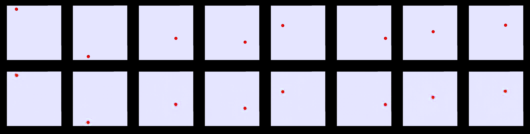

In [15]:
sample = torch.randn(bs, 1024)
compare_x = model.decoder(sample.cuda())


fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x[:8]

print(fixed_x.shape)

#fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)

#print(fixed_x.shape)


compare_x = compare(fixed_x.cuda())

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [16]:
dataset

Dataset ImageFolder
    Number of datapoints: 12001
    Root location: ./
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [17]:
store = np.arange(0)

In [18]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)


z,_,_ = model.encode(fixed_x.cuda())

print(z)
a = z.cpu().detach().numpy()


tensor([[-0.1375, -0.0332, -0.1898,  0.2345, -0.1811, -0.1017, -0.2499, -0.0067,
         -0.1249, -0.0461, -0.0849,  0.1380, -0.0829, -0.1091, -0.0614, -0.1788,
         -0.0265, -0.2665,  0.2254, -0.0428,  0.0625,  0.0571,  0.1409,  0.0985,
          0.1833, -0.3865,  0.2534, -0.0359,  0.1563,  0.0555,  0.0805,  0.0060]],
       device='cuda:0', grad_fn=<AddBackward0>)


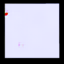

In [19]:
h = z


for ii in range(31):
    h[0][ii] = random.uniform(-1,1)

out_data = model.decode(h)
save_image(out_data.data.cpu(), 'test_image.png')
display(Image('test_image.png', width=700, unconfined=True))

In [20]:

store = []

for ww in range(len(dataset)):
    fixed_x = dataset[ww][0].unsqueeze(0)
    z,_,_ = model.encode(fixed_x.cuda())
    out_data = model.decode(z)
    
    
    z = z.cpu().detach().numpy()
    store.append(z)
    
    #np.append(store,z.cpu())

In [25]:
(store[0])

out_data = model.decode(store[0])
save_image(out_data.data.cpu(), 'test_image.png')
display(Image('test_image.png', width=700, unconfined=True))

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [22]:
np.save('z.npy', store)